In [4]:
import numpy as np
import os
import pickle
from scipy.spatial.distance import pdist, squareform
from scipy import ndimage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# 文件夹路径
folder_path = "./llm_embedding/results/results"
token_info_file = 'score_token_info.pkl'

# 加载评分 token 信息
with open(token_info_file, 'rb') as f:
    token_info = pickle.load(f)

# 分析 punishment 相关信息，筛选编号为奇数的文件
punishment_files = {key: value for key, value in token_info.items()
                    if value['prompt_type'] == 'punishment' and value['prompt_id'] % 2 == 1}

# 按编号分类：TPP（余3）和 SPP（余1）
tpp_files = {key: value for key, value in punishment_files.items() if value['prompt_id'] % 4 == 3}
spp_files = {key: value for key, value in punishment_files.items() if value['prompt_id'] % 4 == 1}

print(f"总样本数: {len(punishment_files)}")
print(f"TPP 样本数: {len(tpp_files)}")
print(f"SPP 样本数: {len(spp_files)}")

# 提取 hidden state 和计算 RDM
def extract_hidden_states(file_list):
    """
    提取指定文件列表中评分 token 的 hidden state 信息。
    返回所有样本的 hidden state 堆叠结果。
    """
    hidden_states = []
    for file_name, info in file_list.items():
        file_path = os.path.join(folder_path, file_name)
        try:
            # 加载 npz 文件
            data = np.load(file_path, allow_pickle=True)
            output_hidden = data['output_hidden']  # (layers, tokens, hidden_size)
            token_index = info['token_index']     # 评分 token 的索引
            
            # 提取评分 token 的 hidden state (所有层)
            # 输出形状: (layers, hidden_size)
            token_hidden = output_hidden[:, token_index, :]
            
            # 将层和 hidden_size 合并成单个向量: (layers * hidden_size)
            token_hidden_flat = token_hidden.flatten()
            
            hidden_states.append(token_hidden_flat)
            data.close()
        except Exception as e:
            print(f"无法处理文件 {file_name}: {e}")
    
    # 返回堆叠后的 hidden state 数组，形状为 (样本数, layers * hidden_size)
    return np.array(hidden_states)

# 提取所有样本、TPP 和 SPP 的 hidden states
all_hidden_states = extract_hidden_states(punishment_files)
tpp_hidden_states = extract_hidden_states(tpp_files)
spp_hidden_states = extract_hidden_states(spp_files)

def calculate_rdm(hidden_states):
    """
    根据样本的 hidden state 计算 RDM（Representational Dissimilarity Matrix）。
    使用 Spearman 相关性计算 dissimilarity。
    返回 RDM 矩阵。
    """
    # 样本数
    n_samples = hidden_states.shape[0]
    
    # 初始化相似性矩阵
    similarity_matrix = np.zeros((n_samples, n_samples))
    
    # 计算两两样本之间的 Spearman 相关性
    for i in range(n_samples):
        for j in range(n_samples):
            if i <= j:  # 对称矩阵，只计算上三角部分
                rho, _ = spearmanr(hidden_states[i], hidden_states[j])
                similarity_matrix[i, j] = rho
                similarity_matrix[j, i] = rho
    
    # 转换为 dissimilarity matrix：1 - similarity
    rdm = 1 - similarity_matrix
    return rdm

# 生成 RDM 矩阵
all_rdm = calculate_rdm(all_hidden_states)
tpp_rdm = calculate_rdm(tpp_hidden_states)
spp_rdm = calculate_rdm(spp_hidden_states)

# 保存 RDM 矩阵
output_dir = "./rdm_results"
os.makedirs(output_dir, exist_ok=True)

np.save(os.path.join(output_dir, 'all_rdm.npy'), all_rdm)
np.save(os.path.join(output_dir, 'tpp_rdm.npy'), tpp_rdm)
np.save(os.path.join(output_dir, 'spp_rdm.npy'), spp_rdm)

print("RDM 矩阵已生成并保存:")
print(f"  综合 RDM: {os.path.join(output_dir, 'all_rdm.npy')}")
print(f"  TPP RDM: {os.path.join(output_dir, 'tpp_rdm.npy')}")
print(f"  SPP RDM: {os.path.join(output_dir, 'spp_rdm.npy')}")

# 可视化 RDM
import matplotlib.pyplot as plt

def plot_rdm(rdm, title, file_path):
    """
    绘制并保存 RDM 热力图。
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(rdm, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Dissimilarity (Euclidean Distance)')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Samples')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

# 绘制并保存所有 RDM 热力图
plot_rdm(all_rdm, "All Samples RDM", os.path.join(output_dir, 'all_rdm.png'))
plot_rdm(tpp_rdm, "TPP Samples RDM", os.path.join(output_dir, 'tpp_rdm.png'))
plot_rdm(spp_rdm, "SPP Samples RDM", os.path.join(output_dir, 'spp_rdm.png'))

print("RDM 热力图已保存:")
print(f"  综合 RDM 图: {os.path.join(output_dir, 'all_rdm.png')}")
print(f"  TPP RDM 图: {os.path.join(output_dir, 'tpp_rdm.png')}")
print(f"  SPP RDM 图: {os.path.join(output_dir, 'spp_rdm.png')}")

总样本数: 108
TPP 样本数: 54
SPP 样本数: 54
RDM 矩阵已生成并保存:
  综合 RDM: ./rdm_results/all_rdm.npy
  TPP RDM: ./rdm_results/tpp_rdm.npy
  SPP RDM: ./rdm_results/spp_rdm.npy
RDM 热力图已保存:
  综合 RDM 图: ./rdm_results/all_rdm.png
  TPP RDM 图: ./rdm_results/tpp_rdm.png
  SPP RDM 图: ./rdm_results/spp_rdm.png


RDM相似度分析

已加载 170 个脑区标签
模型RDM矩阵形状: All=(108, 108), TPP=(54, 54), SPP=(54, 54)

正在计算所有脑区的RDM相似度...

成功分析的脑区数量:
  - Combined: 166 个脑区
  - TPP: 166 个脑区
  - SPP: 166 个脑区

正在保存结果...
结果已保存到: ./similarity_results/similarity_all.txt
结果已保存到: ./similarity_results/similarity_tpp.txt
结果已保存到: ./similarity_results/similarity_spp.txt

正在生成可视化图形...
图形已保存到: ./figures/similarity_combined.png


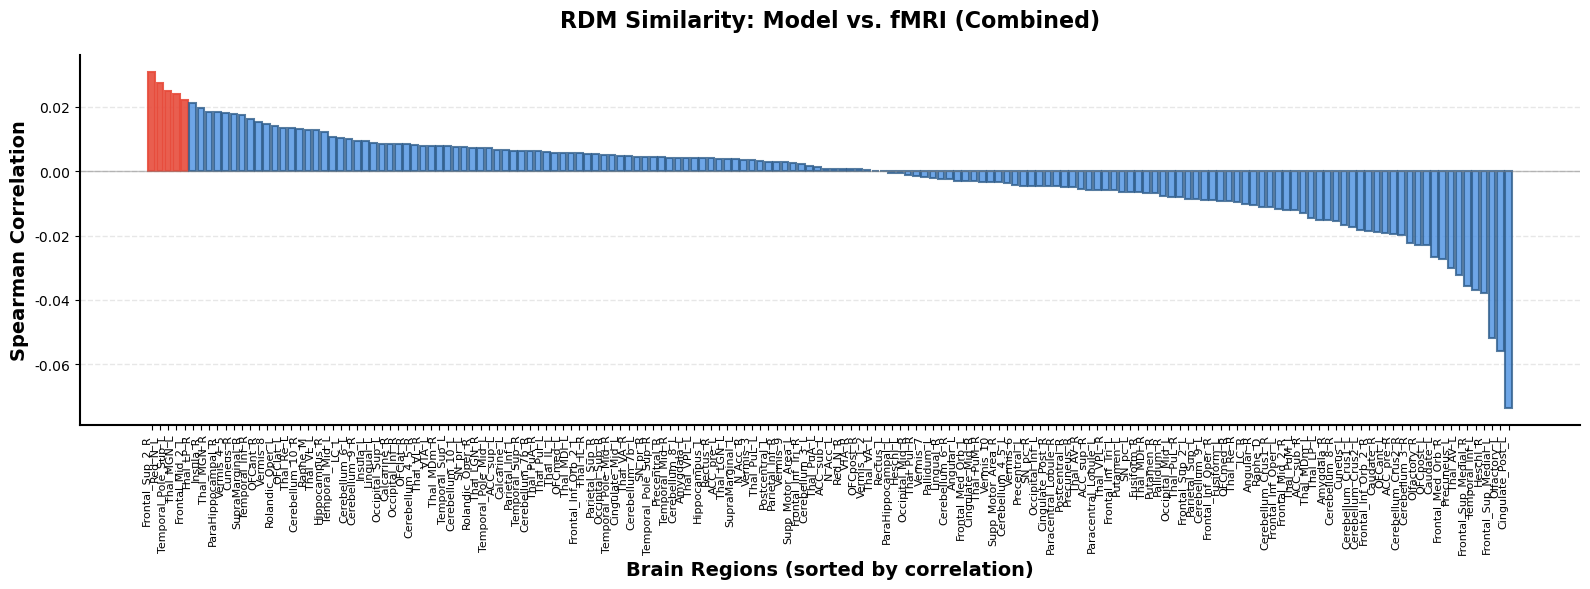


=== Top 10 Regions (Combined) ===
 1. Frontal_Sup_2_R                (ROI   4): 0.0310
 2. Red_N_L                        (ROI 165): 0.0274
 3. Temporal_Pole_Sup_L            (ROI  87): 0.0249
 4. Thal_MGN_L                     (ROI 141): 0.0239
 5. Frontal_Mid_2_L                (ROI   5): 0.0220
 6. Thal_LP_R                      (ROI 124): 0.0213
 7. Insula_R                       (ROI  34): 0.0196
 8. Thal_MGN_R                     (ROI 142): 0.0185
 9. ParaHippocampal_R              (ROI  44): 0.0184
10. Vermis_4_5                     (ROI 115): 0.0182
图形已保存到: ./figures/similarity_tpp.png


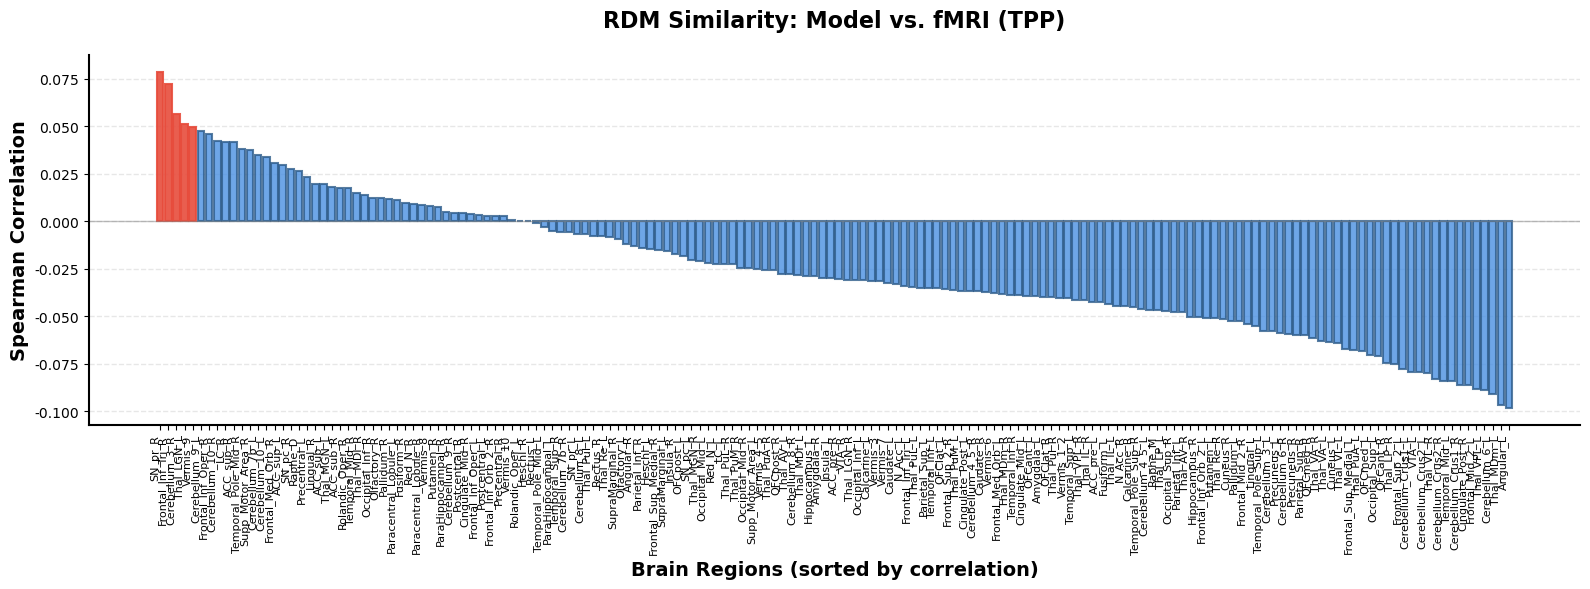


=== Top 10 Regions (TPP) ===
 1. SN_pr_R                        (ROI 164): 0.0787
 2. Frontal_Inf_Tri_R              (ROI  10): 0.0724
 3. Cerebellum_3_R                 (ROI 100): 0.0565
 4. Thal_LGN_L                     (ROI 139): 0.0511
 5. Vermis_9                       (ROI 119): 0.0493
 6. Cerebellum_9_L                 (ROI 109): 0.0477
 7. Frontal_Inf_Oper_R             (ROI   8): 0.0461
 8. Cerebellum_10_R                (ROI 112): 0.0419
 9. LC_R                           (ROI 168): 0.0419
10. ACC_sup_R                      (ROI 156): 0.0417
图形已保存到: ./figures/similarity_spp.png


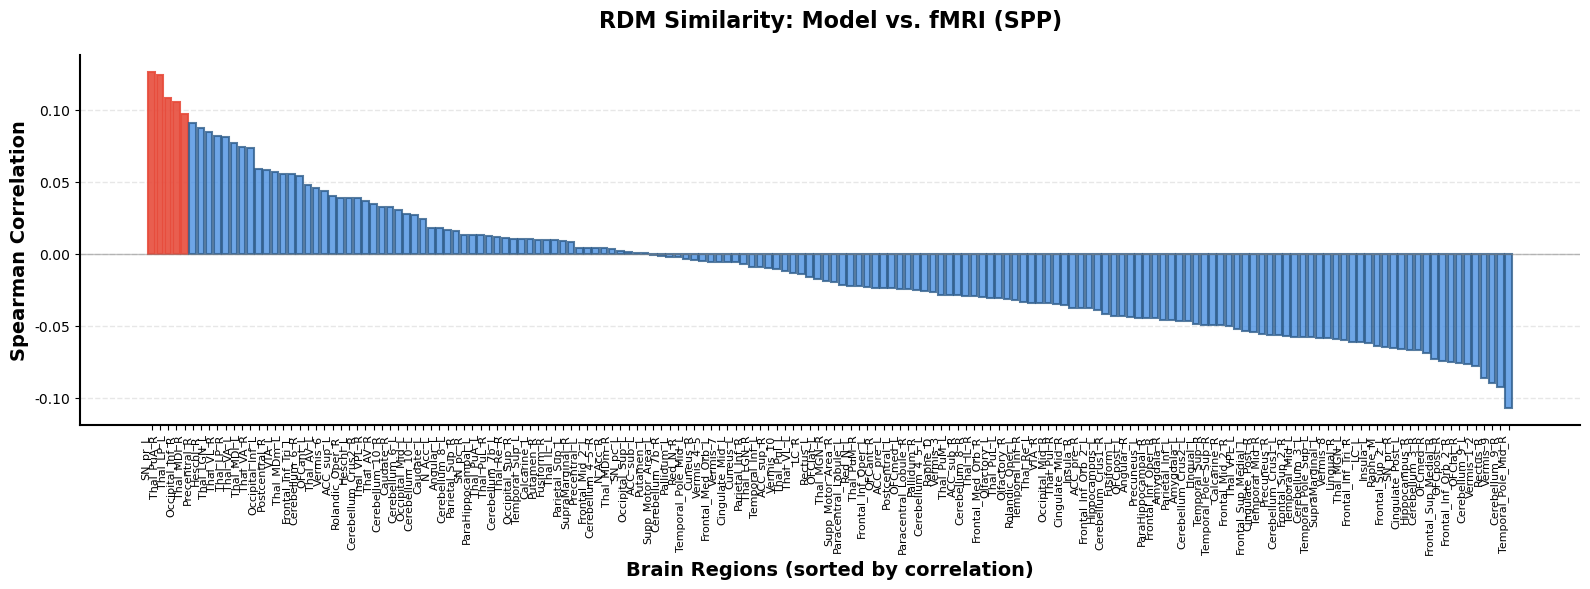


=== Top 10 Regions (SPP) ===
 1. SN_pr_L                        (ROI 163): 0.1265
 2. Thal_PuA_R                     (ROI 148): 0.1244
 3. Thal_LP_L                      (ROI 123): 0.1080
 4. Occipital_Inf_R                (ROI  58): 0.1052
 5. Thal_MDl_R                     (ROI 138): 0.0968
 6. Precentral_R                   (ROI   2): 0.0905
 7. Heschl_R                       (ROI  84): 0.0876
 8. Thal_LGN_L                     (ROI 139): 0.0849
 9. Thal_VL_R                      (ROI 128): 0.0819
10. Thal_LP_R                      (ROI 124): 0.0810

正在生成Top 30脑区的可视化图形...
图形已保存到: ./figures/similarity_combined_top30.png


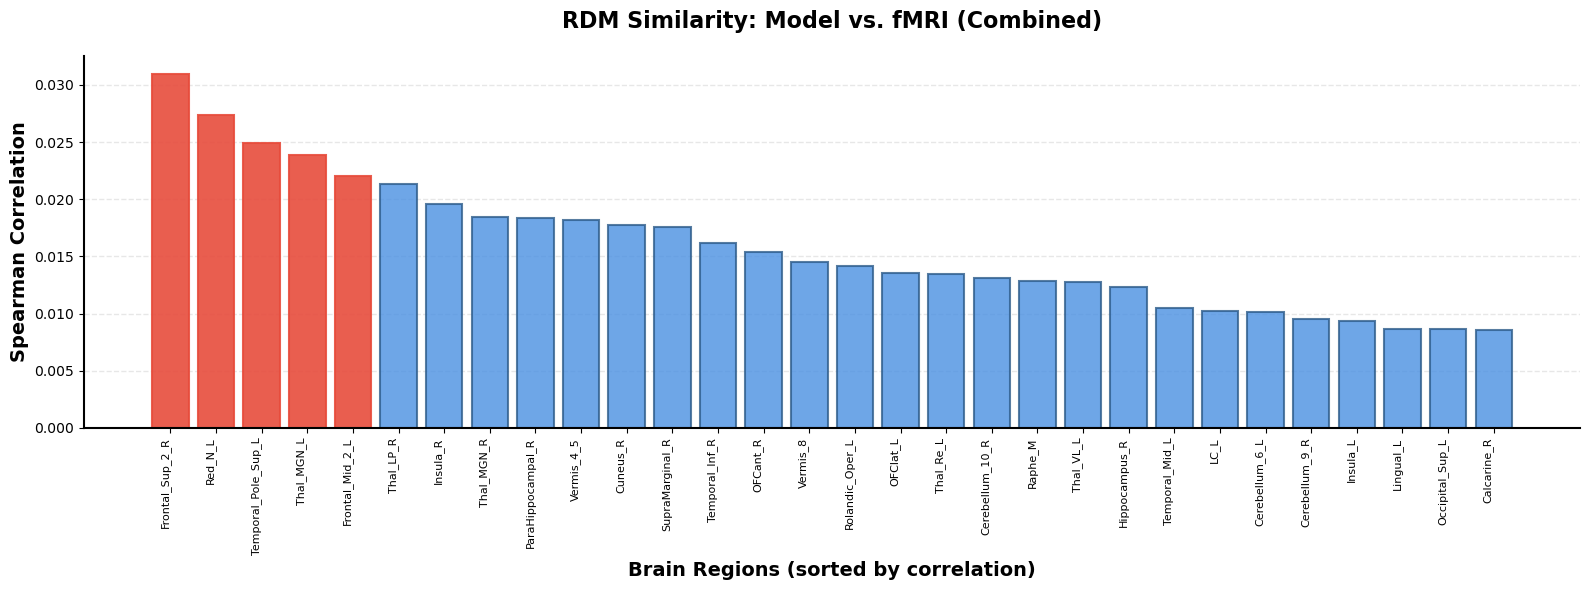


=== Top 10 Regions (Combined) ===
 1. Frontal_Sup_2_R                (ROI   4): 0.0310
 2. Red_N_L                        (ROI 165): 0.0274
 3. Temporal_Pole_Sup_L            (ROI  87): 0.0249
 4. Thal_MGN_L                     (ROI 141): 0.0239
 5. Frontal_Mid_2_L                (ROI   5): 0.0220
 6. Thal_LP_R                      (ROI 124): 0.0213
 7. Insula_R                       (ROI  34): 0.0196
 8. Thal_MGN_R                     (ROI 142): 0.0185
 9. ParaHippocampal_R              (ROI  44): 0.0184
10. Vermis_4_5                     (ROI 115): 0.0182

分析完成！


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os
from pathlib import Path

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class RDMAnalyzer:
    def __init__(self, model_rdm_dir='./rdm_results', 
                 fmri_rdm_dir='./rsa_results',
                 labels_file='./atlas/AAL3v1_labels.txt'):
        """
        初始化RDM分析器
        
        Parameters:
        -----------
        model_rdm_dir : str
            大模型RDM矩阵目录
        fmri_rdm_dir : str
            fMRI RDM矩阵目录
        labels_file : str
            脑区标签文件路径
        """
        self.model_rdm_dir = model_rdm_dir
        self.fmri_rdm_dir = fmri_rdm_dir
        self.labels_file = labels_file
        
        # 加载大模型RDM
        self.model_rdm_all = np.load(os.path.join(model_rdm_dir, 'all_rdm.npy'))
        self.model_rdm_tpp = np.load(os.path.join(model_rdm_dir, 'tpp_rdm.npy'))
        self.model_rdm_spp = np.load(os.path.join(model_rdm_dir, 'spp_rdm.npy'))
        
        # 加载脑区标签
        self.roi_labels = self.load_roi_labels()
        
    def load_roi_labels(self):
        """加载脑区标签"""
        labels = {}
        with open(self.labels_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    roi_id = int(parts[0])
                    roi_name = parts[1]
                    labels[roi_id] = roi_name
        return labels
    
    def compute_rdm_similarity(self, rdm1, rdm2):
        """
        计算两个RDM矩阵的相似度（使用Spearman相关）
        
        Parameters:
        -----------
        rdm1, rdm2 : numpy.ndarray
            RDM矩阵
            
        Returns:
        --------
        correlation : float
            Spearman相关系数
        """
        # 提取上三角部分（不包括对角线）
        triu_indices = np.triu_indices_from(rdm1, k=1)
        rdm1_vector = rdm1[triu_indices]
        rdm2_vector = rdm2[triu_indices]
        
        # 计算Spearman相关
        correlation, _ = spearmanr(rdm1_vector, rdm2_vector)
        
        return correlation
    
    def analyze_all_rois(self):
        """分析所有脑区的RDM相似度"""
        results = {
            'all': {},
            'tpp': {},
            'spp': {}
        }
        
        # 遍历所有脑区文件夹
        for roi_id in range(1, 171):  # roi_001 到 roi_170
            roi_folder = f'roi_{roi_id:03d}'
            roi_path = os.path.join(self.fmri_rdm_dir, roi_folder)
            
            if not os.path.exists(roi_path):
                continue
            
            try:
                # 加载该脑区的RDM矩阵
                rdm_all_path = os.path.join(roi_path, 'rdm_combined.npy')
                rdm_tpp_path = os.path.join(roi_path, 'rdm_tpp.npy')
                rdm_spp_path = os.path.join(roi_path, 'rdm_spp.npy')
                
                if os.path.exists(rdm_all_path):
                    fmri_rdm_all = np.load(rdm_all_path)
                    sim_all = self.compute_rdm_similarity(self.model_rdm_all, fmri_rdm_all)
                    results['all'][roi_id] = sim_all
                
                if os.path.exists(rdm_tpp_path):
                    fmri_rdm_tpp = np.load(rdm_tpp_path)
                    sim_tpp = self.compute_rdm_similarity(self.model_rdm_tpp, fmri_rdm_tpp)
                    results['tpp'][roi_id] = sim_tpp
                
                if os.path.exists(rdm_spp_path):
                    fmri_rdm_spp = np.load(rdm_spp_path)
                    sim_spp = self.compute_rdm_similarity(self.model_rdm_spp, fmri_rdm_spp)
                    results['spp'][roi_id] = sim_spp
                    
            except Exception as e:
                print(f"处理脑区 {roi_id} 时出错: {e}")
                continue
        
        return results
    
    def plot_results(self, results, condition='all', top_n=None, figsize=(16, 6), save_path=None):
        """
        可视化RDM相似度结果
        
        Parameters:
        -----------
        results : dict
            分析结果
        condition : str
            条件类型 ('all', 'tpp', 'spp')
        top_n : int, optional
            只显示前N个脑区，None表示显示全部
        figsize : tuple
            图形大小
        save_path : str, optional
            保存路径
        """
        data = results[condition]
        
        # 按相似度排序
        sorted_rois = sorted(data.items(), key=lambda x: x[1], reverse=True)
        
        if top_n:
            sorted_rois = sorted_rois[:top_n]
        
        roi_ids = [roi_id for roi_id, _ in sorted_rois]
        similarities = [sim for _, sim in sorted_rois]
        roi_names = [self.roi_labels.get(roi_id, f'ROI_{roi_id}') for roi_id in roi_ids]
        
        # 创建图形
        fig, ax = plt.subplots(figsize=figsize)
        
        # 绘制柱状图
        bars = ax.bar(range(len(similarities)), similarities, 
                      color='#4A90E2', alpha=0.8, edgecolor='#2E5C8A', linewidth=1.5)
        
        # 设置坐标轴
        ax.set_ylabel('Spearman Correlation', fontsize=14, fontweight='bold')
        ax.set_xlabel('Brain Regions (sorted by correlation)', fontsize=14, fontweight='bold')
        
        # 设置标题
        condition_names = {'all': 'Combined', 'tpp': 'TPP', 'spp': 'SPP'}
        ax.set_title(f'RDM Similarity: Model vs. fMRI ({condition_names[condition]})', 
                    fontsize=16, fontweight='bold', pad=20)
        
        # 取消上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置x轴刻度
        ax.set_xticks(range(len(roi_names)))
        ax.set_xticklabels(roi_names, rotation=90, ha='right', fontsize=8)
        
        # 设置网格
        ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=1)
        ax.set_axisbelow(True)
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        
        # 高亮显示前5名
        if len(bars) >= 5:
            for i in range(5):
                bars[i].set_color('#E74C3C')
                bars[i].set_alpha(0.9)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图形
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图形已保存到: {save_path}")
        
        plt.show()
        
        # 打印前10名
        print(f"\n=== Top 10 Regions ({condition_names[condition]}) ===")
        for i, (roi_id, sim) in enumerate(sorted_rois[:10], 1):
            roi_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
            print(f"{i:2d}. {roi_name:30s} (ROI {roi_id:3d}): {sim:.4f}")
    
    def save_results(self, results, output_dir='./similarity_results'):
        """保存结果到文件"""
        os.makedirs(output_dir, exist_ok=True)
        
        for condition in ['all', 'tpp', 'spp']:
            data = results[condition]
            sorted_rois = sorted(data.items(), key=lambda x: x[1], reverse=True)
            
            output_file = os.path.join(output_dir, f'similarity_{condition}.txt')
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"ROI_ID\tROI_Name\tSpearman_Correlation\n")
                for roi_id, sim in sorted_rois:
                    roi_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
                    f.write(f"{roi_id}\t{roi_name}\t{sim:.6f}\n")
            
            print(f"结果已保存到: {output_file}")
            
            # 同时保存为numpy格式
            np.save(os.path.join(output_dir, f'similarity_{condition}.npy'), 
                   np.array([(roi_id, sim) for roi_id, sim in sorted_rois]))


def main():
    """主函数"""
    print("=" * 60)
    print("RDM相似度分析")
    print("=" * 60)
    
    # 创建分析器
    analyzer = RDMAnalyzer()
    
    print(f"\n已加载 {len(analyzer.roi_labels)} 个脑区标签")
    print(f"模型RDM矩阵形状: All={analyzer.model_rdm_all.shape}, "
          f"TPP={analyzer.model_rdm_tpp.shape}, SPP={analyzer.model_rdm_spp.shape}")
    
    # 分析所有脑区
    print("\n正在计算所有脑区的RDM相似度...")
    results = analyzer.analyze_all_rois()
    
    print(f"\n成功分析的脑区数量:")
    print(f"  - Combined: {len(results['all'])} 个脑区")
    print(f"  - TPP: {len(results['tpp'])} 个脑区")
    print(f"  - SPP: {len(results['spp'])} 个脑区")
    
    # 保存结果
    print("\n正在保存结果...")
    analyzer.save_results(results)
    
    # 可视化结果
    print("\n正在生成可视化图形...")
    
    # 创建输出目录
    os.makedirs('./figures', exist_ok=True)
    
    # 绘制三个条件的图
    analyzer.plot_results(results, condition='all', 
                         save_path='./figures/similarity_combined.png')
    
    analyzer.plot_results(results, condition='tpp', 
                         save_path='./figures/similarity_tpp.png')
    
    analyzer.plot_results(results, condition='spp', 
                         save_path='./figures/similarity_spp.png')
    
    # 也可以只显示前30个脑区
    print("\n正在生成Top 30脑区的可视化图形...")
    analyzer.plot_results(results, condition='all', top_n=30,
                         save_path='./figures/similarity_combined_top30.png')
    
    print("\n分析完成！")


if __name__ == '__main__':
    main()

RDM相似度分析

已加载 170 个脑区标签
模型RDM矩阵形状: All=(108, 108), TPP=(54, 54), SPP=(54, 54)

正在计算所有脑区的RDM相似度...

成功分析的脑区数量:
  - Combined: 166 个脑区
  - TPP: 166 个脑区
  - SPP: 166 个脑区

正在保存结果...
结果已保存到: ./similarity_results/similarity_all.txt
结果已保存到: ./similarity_results/similarity_tpp.txt
结果已保存到: ./similarity_results/similarity_spp.txt

正在生成Top 30脑区的可视化图形...
图形已保存到: ./figures/similarity_combined_top30.png


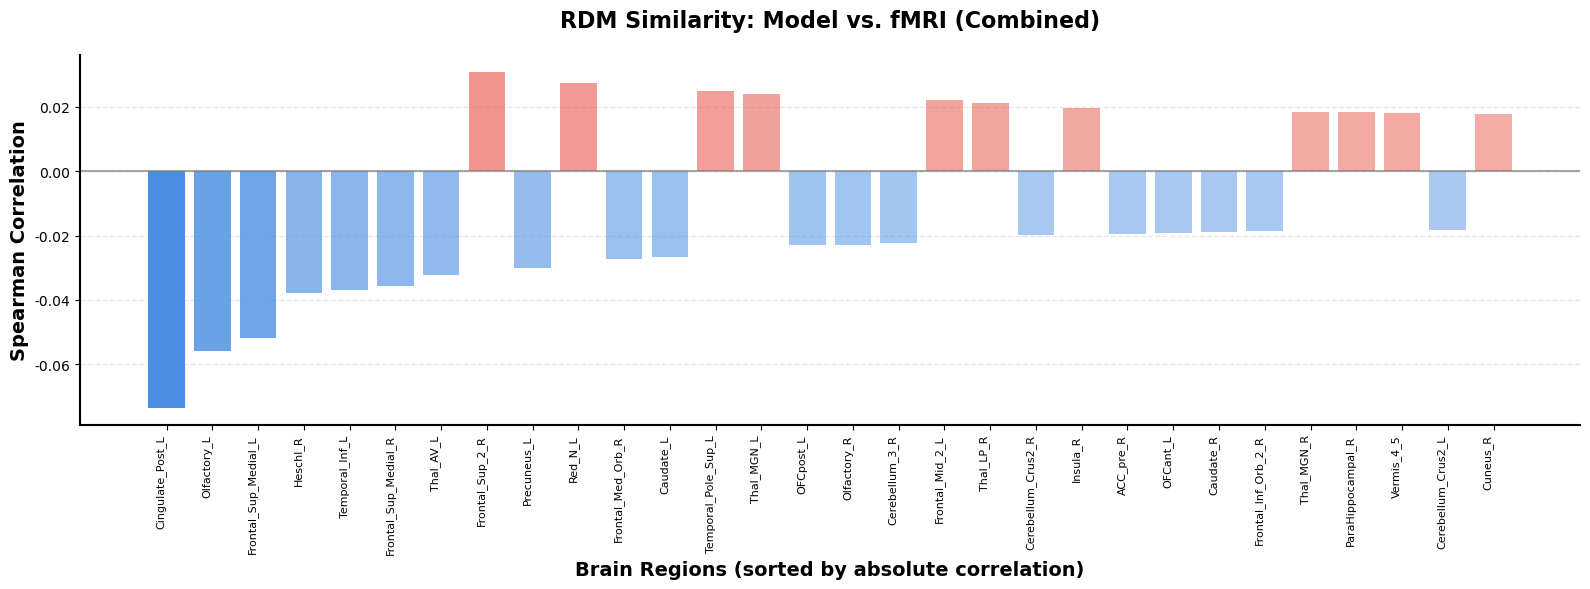


=== Top 10 Regions by Absolute Correlation (Combined) ===
 1. Cingulate_Post_L               (ROI  39): -0.0736
 2. Olfactory_L                    (ROI  17): -0.0558
 3. Frontal_Sup_Medial_L           (ROI  19): -0.0518
 4. Heschl_R                       (ROI  84): -0.0379
 5. Temporal_Inf_L                 (ROI  93): -0.0368
 6. Frontal_Sup_Medial_R           (ROI  20): -0.0356
 7. Thal_AV_L                      (ROI 121): -0.0324
 8. Frontal_Sup_2_R                (ROI   4): +0.0310
 9. Precuneus_L                    (ROI  71): -0.0301
10. Red_N_L                        (ROI 165): +0.0274
图形已保存到: ./figures/similarity_tpp_top30.png


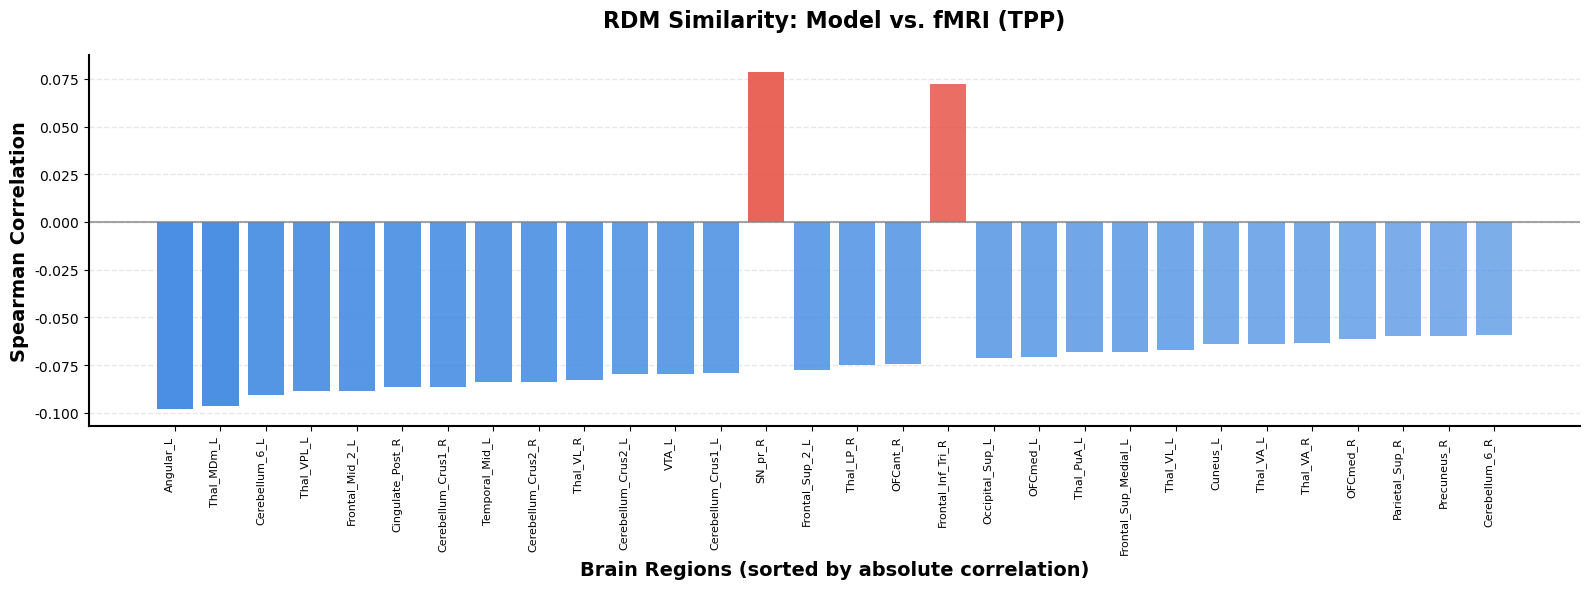


=== Top 10 Regions by Absolute Correlation (TPP) ===
 1. Angular_L                      (ROI  69): -0.0982
 2. Thal_MDm_L                     (ROI 135): -0.0965
 3. Cerebellum_6_L                 (ROI 103): -0.0907
 4. Thal_VPL_L                     (ROI 129): -0.0887
 5. Frontal_Mid_2_L                (ROI   5): -0.0885
 6. Cingulate_Post_R               (ROI  40): -0.0864
 7. Cerebellum_Crus1_R             (ROI  96): -0.0863
 8. Temporal_Mid_L                 (ROI  89): -0.0841
 9. Cerebellum_Crus2_R             (ROI  98): -0.0839
10. Thal_VL_R                      (ROI 128): -0.0830
图形已保存到: ./figures/similarity_spp_top30.png


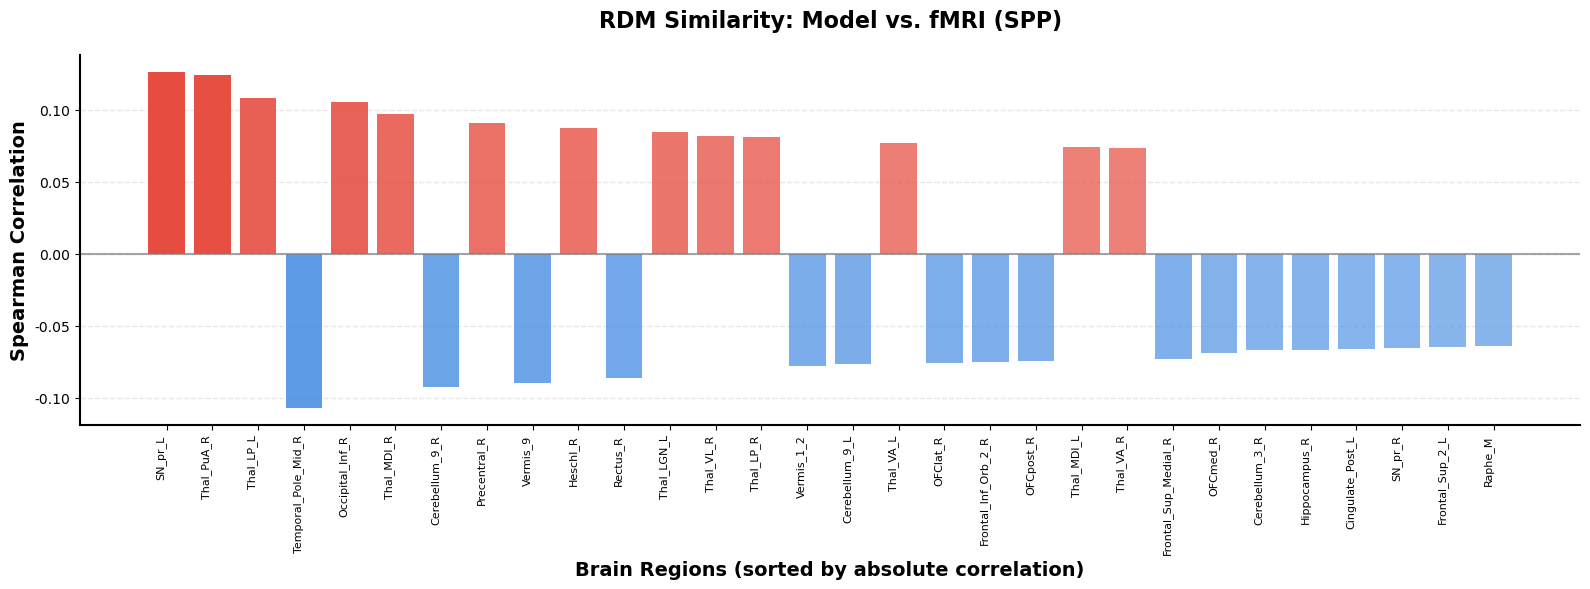


=== Top 10 Regions by Absolute Correlation (SPP) ===
 1. SN_pr_L                        (ROI 163): +0.1265
 2. Thal_PuA_R                     (ROI 148): +0.1244
 3. Thal_LP_L                      (ROI 123): +0.1080
 4. Temporal_Pole_Mid_R            (ROI  92): -0.1071
 5. Occipital_Inf_R                (ROI  58): +0.1052
 6. Thal_MDl_R                     (ROI 138): +0.0968
 7. Cerebellum_9_R                 (ROI 110): -0.0924
 8. Precentral_R                   (ROI   2): +0.0905
 9. Vermis_9                       (ROI 119): -0.0902
10. Heschl_R                       (ROI  84): +0.0876

分析完成！


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os
from pathlib import Path

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class RDMAnalyzer:
    def __init__(self, model_rdm_dir='./rdm_results', 
                 fmri_rdm_dir='./rsa_results',
                 labels_file='./atlas/AAL3v1_labels.txt'):
        """
        初始化RDM分析器
        
        Parameters:
        -----------
        model_rdm_dir : str
            大模型RDM矩阵目录
        fmri_rdm_dir : str
            fMRI RDM矩阵目录
        labels_file : str
            脑区标签文件路径
        """
        self.model_rdm_dir = model_rdm_dir
        self.fmri_rdm_dir = fmri_rdm_dir
        self.labels_file = labels_file
        
        # 加载大模型RDM
        self.model_rdm_all = np.load(os.path.join(model_rdm_dir, 'all_rdm.npy'))
        self.model_rdm_tpp = np.load(os.path.join(model_rdm_dir, 'tpp_rdm.npy'))
        self.model_rdm_spp = np.load(os.path.join(model_rdm_dir, 'spp_rdm.npy'))
        
        # 加载脑区标签
        self.roi_labels = self.load_roi_labels()
        
    def load_roi_labels(self):
        """加载脑区标签"""
        labels = {}
        with open(self.labels_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    roi_id = int(parts[0])
                    roi_name = parts[1]
                    labels[roi_id] = roi_name
        return labels
    
    def compute_rdm_similarity(self, rdm1, rdm2):
        """
        计算两个RDM矩阵的相似度（使用Spearman相关）
        
        Parameters:
        -----------
        rdm1, rdm2 : numpy.ndarray
            RDM矩阵
            
        Returns:
        --------
        correlation : float
            Spearman相关系数
        """
        # 提取上三角部分（不包括对角线）
        triu_indices = np.triu_indices_from(rdm1, k=1)
        rdm1_vector = rdm1[triu_indices]
        rdm2_vector = rdm2[triu_indices]
        
        # 计算Spearman相关
        correlation, _ = spearmanr(rdm1_vector, rdm2_vector)
        
        return correlation
    
    def analyze_all_rois(self):
        """分析所有脑区的RDM相似度"""
        results = {
            'all': {},
            'tpp': {},
            'spp': {}
        }
        
        # 遍历所有脑区文件夹
        for roi_id in range(1, 171):  # roi_001 到 roi_170
            roi_folder = f'roi_{roi_id:03d}'
            roi_path = os.path.join(self.fmri_rdm_dir, roi_folder)
            
            if not os.path.exists(roi_path):
                continue
            
            try:
                # 加载该脑区的RDM矩阵
                rdm_all_path = os.path.join(roi_path, 'rdm_combined.npy')
                rdm_tpp_path = os.path.join(roi_path, 'rdm_tpp.npy')
                rdm_spp_path = os.path.join(roi_path, 'rdm_spp.npy')
                
                if os.path.exists(rdm_all_path):
                    fmri_rdm_all = np.load(rdm_all_path)
                    sim_all = self.compute_rdm_similarity(self.model_rdm_all, fmri_rdm_all)
                    results['all'][roi_id] = sim_all
                
                if os.path.exists(rdm_tpp_path):
                    fmri_rdm_tpp = np.load(rdm_tpp_path)
                    sim_tpp = self.compute_rdm_similarity(self.model_rdm_tpp, fmri_rdm_tpp)
                    results['tpp'][roi_id] = sim_tpp
                
                if os.path.exists(rdm_spp_path):
                    fmri_rdm_spp = np.load(rdm_spp_path)
                    sim_spp = self.compute_rdm_similarity(self.model_rdm_spp, fmri_rdm_spp)
                    results['spp'][roi_id] = sim_spp
                    
            except Exception as e:
                print(f"处理脑区 {roi_id} 时出错: {e}")
                continue
        
        return results
    
    def plot_results(self, results, condition='all', top_n=None, figsize=(16, 6), save_path=None):
        """
        可视化RDM相似度结果
        
        Parameters:
        -----------
        results : dict
            分析结果
        condition : str
            条件类型 ('all', 'tpp', 'spp')
        top_n : int, optional
            只显示前N个脑区，None表示显示全部
        figsize : tuple
            图形大小
        save_path : str, optional
            保存路径
        """
        data = results[condition]
        
        # 按绝对值大小排序（从大到小）
        sorted_rois = sorted(data.items(), key=lambda x: abs(x[1]), reverse=True)
        
        if top_n:
            sorted_rois = sorted_rois[:top_n]
        
        roi_ids = [roi_id for roi_id, _ in sorted_rois]
        similarities = [sim for _, sim in sorted_rois]
        roi_names = [self.roi_labels.get(roi_id, f'ROI_{roi_id}') for roi_id in roi_ids]
        
        # 创建图形
        fig, ax = plt.subplots(figsize=figsize)
        
        # 为每个柱子分配颜色（正值红色，负值蓝色，随绝对值变小颜色变淡）
        colors = []
        max_abs_value = max(abs(s) for s in similarities) if similarities else 1

        for sim in similarities:
            if sim >= 0:
                # 正值：红色，alpha根据绝对值大小调整
                alpha = 0.3 + 0.7 * (abs(sim) / max_abs_value)  # 范围从0.3到1.0
                colors.append((0.9, 0.3, 0.25, alpha))  # 红色 (#E74C3C)
            else:
                # 负值：蓝色，alpha根据绝对值大小调整
                alpha = 0.3 + 0.7 * (abs(sim) / max_abs_value)  # 范围从0.3到1.0
                colors.append((0.29, 0.56, 0.89, alpha))  # 蓝色 (#4A90E2)
        
        # 绘制柱状图
        bars = ax.bar(range(len(similarities)), similarities, 
                      color=colors, edgecolor='none')
        
        # 设置坐标轴
        ax.set_ylabel('Spearman Correlation', fontsize=14, fontweight='bold')
        ax.set_xlabel('Brain Regions (sorted by absolute correlation)', fontsize=14, fontweight='bold')
        
        # 设置标题
        condition_names = {'all': 'Combined', 'tpp': 'TPP', 'spp': 'SPP'}
        ax.set_title(f'RDM Similarity: Model vs. fMRI ({condition_names[condition]})', 
                    fontsize=16, fontweight='bold', pad=20)
        
        # 取消上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置x轴刻度
        ax.set_xticks(range(len(roi_names)))
        ax.set_xticklabels(roi_names, rotation=90, ha='right', fontsize=8)
        
        # 设置网格
        ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=1)
        ax.set_axisbelow(True)
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图形
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图形已保存到: {save_path}")
        
        plt.show()
        
        # 打印前10名（按绝对值）
        print(f"\n=== Top 10 Regions by Absolute Correlation ({condition_names[condition]}) ===")
        for i, (roi_id, sim) in enumerate(sorted_rois[:10], 1):
            roi_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
            print(f"{i:2d}. {roi_name:30s} (ROI {roi_id:3d}): {sim:+.4f}")
    
    def save_results(self, results, output_dir='./similarity_results'):
        """保存结果到文件"""
        os.makedirs(output_dir, exist_ok=True)
        
        for condition in ['all', 'tpp', 'spp']:
            data = results[condition]
            sorted_rois = sorted(data.items(), key=lambda x: abs(x[1]), reverse=True)
            
            output_file = os.path.join(output_dir, f'similarity_{condition}.txt')
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"ROI_ID\tROI_Name\tSpearman_Correlation\tAbs_Correlation\n")
                for roi_id, sim in sorted_rois:
                    roi_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
                    f.write(f"{roi_id}\t{roi_name}\t{sim:.6f}\t{abs(sim):.6f}\n")
            
            print(f"结果已保存到: {output_file}")
            
            # 同时保存为numpy格式
            np.save(os.path.join(output_dir, f'similarity_{condition}.npy'), 
                   np.array([(roi_id, sim) for roi_id, sim in sorted_rois]))


def main():
    """主函数"""
    print("=" * 60)
    print("RDM相似度分析")
    print("=" * 60)
    
    # 创建分析器
    analyzer = RDMAnalyzer()
    
    print(f"\n已加载 {len(analyzer.roi_labels)} 个脑区标签")
    print(f"模型RDM矩阵形状: All={analyzer.model_rdm_all.shape}, "
          f"TPP={analyzer.model_rdm_tpp.shape}, SPP={analyzer.model_rdm_spp.shape}")
    
    # 分析所有脑区
    print("\n正在计算所有脑区的RDM相似度...")
    results = analyzer.analyze_all_rois()
    
    print(f"\n成功分析的脑区数量:")
    print(f"  - Combined: {len(results['all'])} 个脑区")
    print(f"  - TPP: {len(results['tpp'])} 个脑区")
    print(f"  - SPP: {len(results['spp'])} 个脑区")
    
    # 保存结果
    print("\n正在保存结果...")
    analyzer.save_results(results)
    
    # 创建输出目录
    os.makedirs('./figures', exist_ok=True)
    
    # 只显示前30个脑区（按绝对值排序）
    print("\n正在生成Top 30脑区的可视化图形...")
    analyzer.plot_results(results, condition='all', top_n=30,
                         save_path='./figures/similarity_combined_top30.png')
    
    analyzer.plot_results(results, condition='tpp', top_n=30,
                         save_path='./figures/similarity_tpp_top30.png')
    
    analyzer.plot_results(results, condition='spp', top_n=30,
                         save_path='./figures/similarity_spp_top30.png')
    
    print("\n分析完成！")


if __name__ == '__main__':
    main()

RDM相似度分析

已加载 170 个脑区标签
已创建 124 个脑区名称映射
模型RDM矩阵形状: All=(108, 108), TPP=(54, 54), SPP=(54, 54)

正在计算所有脑区的RDM相似度...

成功分析的脑区数量:
  - Combined: 166 个脑区
  - TPP: 166 个脑区
  - SPP: 166 个脑区

正在保存结果...
结果已保存到: ./similarity_results/similarity_all.txt
结果已保存到: ./similarity_results/similarity_tpp.txt
结果已保存到: ./similarity_results/similarity_spp.txt

正在生成Top 30脑区的可视化图形（使用缩写）...
图形已保存到: ./figures/similarity_combined_top30_abbrev.png


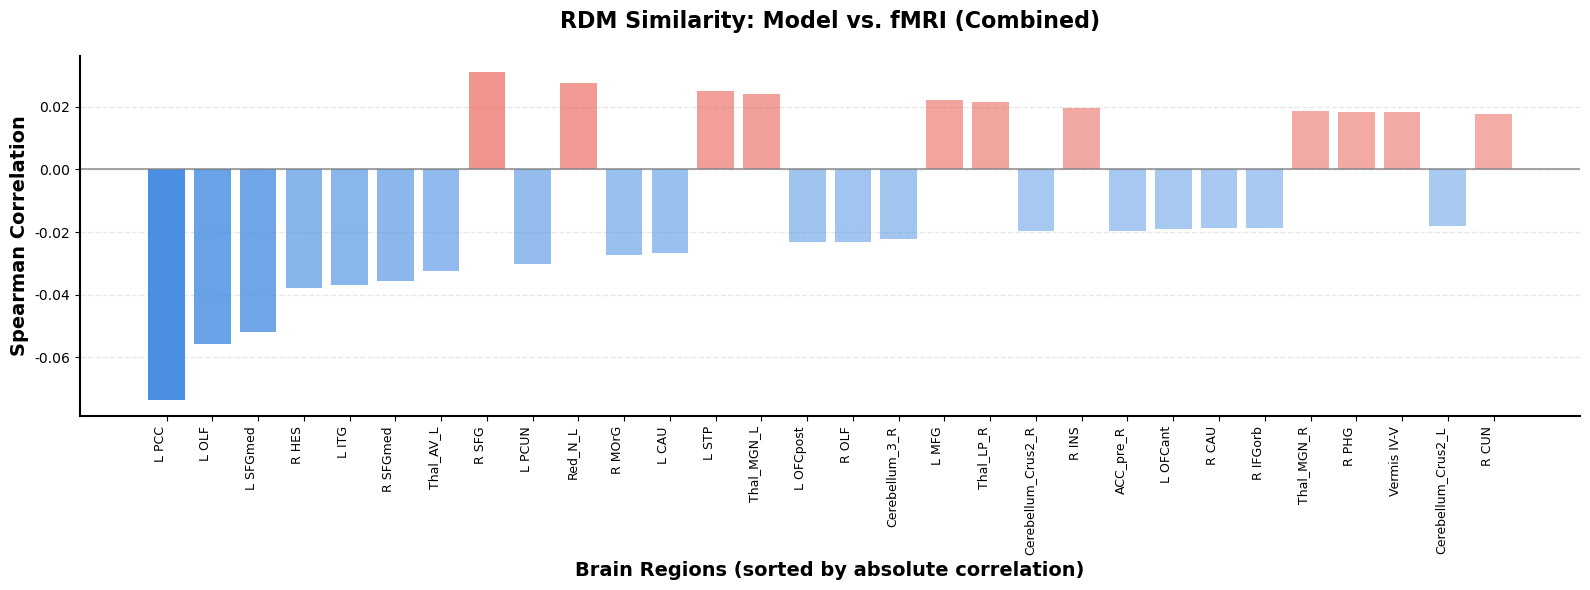


=== Top 50 Regions by Absolute Correlation (Combined) ===
 1. Cingulate_Post_L               | left posterior cingulate cortex                         [L PCC       ] (ROI  39): -0.0736
 2. Olfactory_L                    | left olfactory cortex                                   [L OLF       ] (ROI  17): -0.0558
 3. Frontal_Sup_Medial_L           | left superior frontal gyrus, medial                     [L SFGmed    ] (ROI  19): -0.0518
 4. Heschl_R                       | right Heschl gyrus                                      [R HES       ] (ROI  84): -0.0379
 5. Temporal_Inf_L                 | left inferior temporal gyrus                            [L ITG       ] (ROI  93): -0.0368
 6. Frontal_Sup_Medial_R           | right superior frontal gyrus, medial                    [R SFGmed    ] (ROI  20): -0.0356
 7. Thal_AV_L                      | Thal_AV_L                                               [Thal_AV_L   ] (ROI 121): -0.0324
 8. Frontal_Sup_2_R                | right superior 

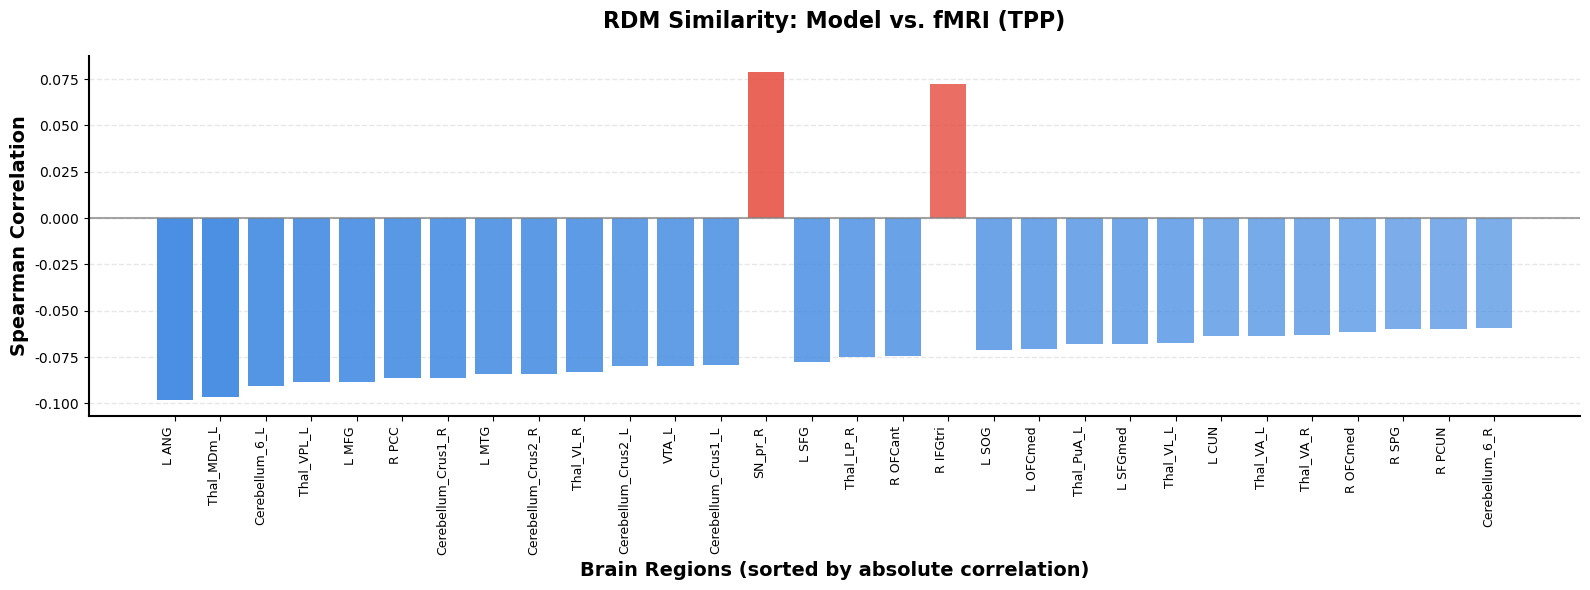


=== Top 50 Regions by Absolute Correlation (TPP) ===
 1. Angular_L                      | left angular gyrus                                      [L ANG       ] (ROI  69): -0.0982
 2. Thal_MDm_L                     | Thal_MDm_L                                              [Thal_MDm_L  ] (ROI 135): -0.0965
 3. Cerebellum_6_L                 | Cerebellum_6_L                                          [Cerebellum_6_L] (ROI 103): -0.0907
 4. Thal_VPL_L                     | Thal_VPL_L                                              [Thal_VPL_L  ] (ROI 129): -0.0887
 5. Frontal_Mid_2_L                | left middle frontal gyrus                               [L MFG       ] (ROI   5): -0.0885
 6. Cingulate_Post_R               | right posterior cingulate cortex                        [R PCC       ] (ROI  40): -0.0864
 7. Cerebellum_Crus1_R             | Cerebellum_Crus1_R                                      [Cerebellum_Crus1_R] (ROI  96): -0.0863
 8. Temporal_Mid_L                 | left middle 

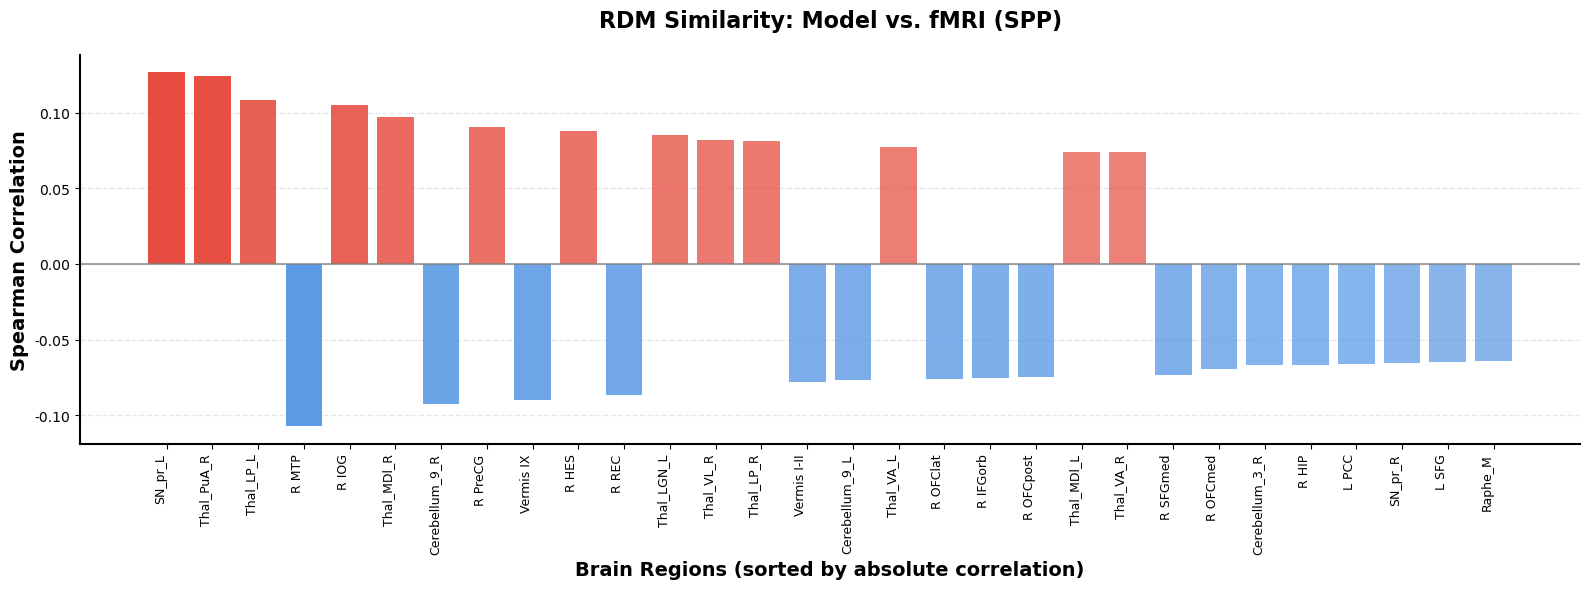


=== Top 50 Regions by Absolute Correlation (SPP) ===
 1. SN_pr_L                        | SN_pr_L                                                 [SN_pr_L     ] (ROI 163): +0.1265
 2. Thal_PuA_R                     | Thal_PuA_R                                              [Thal_PuA_R  ] (ROI 148): +0.1244
 3. Thal_LP_L                      | Thal_LP_L                                               [Thal_LP_L   ] (ROI 123): +0.1080
 4. Temporal_Pole_Mid_R            | right middle temporal pole                              [R MTP       ] (ROI  92): -0.1071
 5. Occipital_Inf_R                | right inferior occipital gyrus                          [R IOG       ] (ROI  58): +0.1052
 6. Thal_MDl_R                     | Thal_MDl_R                                              [Thal_MDl_R  ] (ROI 138): +0.0968
 7. Cerebellum_9_R                 | Cerebellum_9_R                                          [Cerebellum_9_R] (ROI 110): -0.0924
 8. Precentral_R                   | right precentral g

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os
from pathlib import Path

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class RDMAnalyzer:
    def __init__(self, model_rdm_dir='./rdm_results', 
                 fmri_rdm_dir='./rsa_results',
                 labels_file='./atlas/AAL3v1_labels.txt'):
        """
        初始化RDM分析器
        
        Parameters:
        -----------
        model_rdm_dir : str
            大模型RDM矩阵目录
        fmri_rdm_dir : str
            fMRI RDM矩阵目录
        labels_file : str
            脑区标签文件路径
        """
        self.model_rdm_dir = model_rdm_dir
        self.fmri_rdm_dir = fmri_rdm_dir
        self.labels_file = labels_file
        
        # 加载大模型RDM
        self.model_rdm_all = np.load(os.path.join(model_rdm_dir, 'all_rdm.npy'))
        self.model_rdm_tpp = np.load(os.path.join(model_rdm_dir, 'tpp_rdm.npy'))
        self.model_rdm_spp = np.load(os.path.join(model_rdm_dir, 'spp_rdm.npy'))
        
        # 加载脑区标签
        self.roi_labels = self.load_roi_labels()
        
        # 创建AAL3名称到完整解剖名称的映射
        self.name_mapping = self.create_name_mapping()
        
    def load_roi_labels(self):
        """加载脑区标签"""
        labels = {}
        with open(self.labels_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    roi_id = int(parts[0])
                    roi_name = parts[1]
                    labels[roi_id] = roi_name
        return labels
    
    def create_name_mapping(self):
        """
        创建AAL3模板名称到完整解剖名称的映射
        
        Returns:
        --------
        mapping : dict
            名称映射字典，格式为 {'AAL3_name': ('full_name', 'abbreviation')}
        """
        mapping = {
            # Frontal lobe - Superior
            'Frontal_Sup_2_L': ('left superior frontal gyrus', 'L SFG'),
            'Frontal_Sup_2_R': ('right superior frontal gyrus', 'R SFG'),
            'Frontal_Sup_L': ('left superior frontal gyrus', 'L SFG'),
            'Frontal_Sup_R': ('right superior frontal gyrus', 'R SFG'),
            
            # Frontal lobe - Middle
            'Frontal_Mid_2_L': ('left middle frontal gyrus', 'L MFG'),
            'Frontal_Mid_2_R': ('right middle frontal gyrus', 'R MFG'),
            'Frontal_Mid_L': ('left middle frontal gyrus', 'L MFG'),
            'Frontal_Mid_R': ('right middle frontal gyrus', 'R MFG'),
            
            # Frontal lobe - Inferior
            'Frontal_Inf_Oper_L': ('left inferior frontal gyrus, opercular part', 'L IFGoper'),
            'Frontal_Inf_Oper_R': ('right inferior frontal gyrus, opercular part', 'R IFGoper'),
            'Frontal_Inf_Tri_L': ('left inferior frontal gyrus, triangular part', 'L IFGtri'),
            'Frontal_Inf_Tri_R': ('right inferior frontal gyrus, triangular part', 'R IFGtri'),
            'Frontal_Inf_Orb_2_L': ('left inferior frontal gyrus, orbital part', 'L IFGorb'),
            'Frontal_Inf_Orb_2_R': ('right inferior frontal gyrus, orbital part', 'R IFGorb'),
            
            # Rolandic and motor areas
            'Rolandic_Oper_L': ('left rolandic operculum', 'L ROL'),
            'Rolandic_Oper_R': ('right rolandic operculum', 'R ROL'),
            'Supp_Motor_Area_L': ('left supplementary motor area', 'L SMA'),
            'Supp_Motor_Area_R': ('right supplementary motor area', 'R SMA'),
            'Precentral_L': ('left precentral gyrus', 'L PreCG'),
            'Precentral_R': ('right precentral gyrus', 'R PreCG'),
            'Postcentral_L': ('left postcentral gyrus', 'L PostCG'),
            'Postcentral_R': ('right postcentral gyrus', 'R PostCG'),
            
            # Olfactory and medial frontal
            'Olfactory_L': ('left olfactory cortex', 'L OLF'),
            'Olfactory_R': ('right olfactory cortex', 'R OLF'),
            'Frontal_Sup_Medial_L': ('left superior frontal gyrus, medial', 'L SFGmed'),
            'Frontal_Sup_Medial_R': ('right superior frontal gyrus, medial', 'R SFGmed'),
            'Frontal_Med_Orb_L': ('left medial orbital gyrus', 'L MOrG'),
            'Frontal_Med_Orb_R': ('right medial orbital gyrus', 'R MOrG'),
            'Rectus_L': ('left rectus gyrus', 'L REC'),
            'Rectus_R': ('right rectus gyrus', 'R REC'),
            
            # Orbitofrontal cortex
            'OFCmed_L': ('left medial orbitofrontal cortex', 'L OFCmed'),
            'OFCmed_R': ('right medial orbitofrontal cortex', 'R OFCmed'),
            'OFCant_L': ('left anterior orbitofrontal cortex', 'L OFCant'),
            'OFCant_R': ('right anterior orbitofrontal cortex', 'R OFCant'),
            'OFCpost_L': ('left posterior orbitofrontal cortex', 'L OFCpost'),
            'OFCpost_R': ('right posterior orbitofrontal cortex', 'R OFCpost'),
            'OFClat_L': ('left lateral orbitofrontal cortex', 'L OFClat'),
            'OFClat_R': ('right lateral orbitofrontal cortex', 'R OFClat'),
            
            # Parietal lobe - Superior and Inferior
            'Parietal_Sup_L': ('left superior parietal gyrus', 'L SPG'),
            'Parietal_Sup_R': ('right superior parietal gyrus', 'R SPG'),
            'Parietal_Inf_L': ('left inferior parietal gyrus', 'L IPG'),
            'Parietal_Inf_R': ('right inferior parietal gyrus', 'R IPG'),
            'SupraMarginal_L': ('left supramarginal gyrus', 'L SMG'),
            'SupraMarginal_R': ('right supramarginal gyrus', 'R SMG'),
            'Angular_L': ('left angular gyrus', 'L ANG'),
            'Angular_R': ('right angular gyrus', 'R ANG'),
            
            # Parietal lobe - Medial
            'Precuneus_L': ('left precuneus', 'L PCUN'),
            'Precuneus_R': ('right precuneus', 'R PCUN'),
            'Paracentral_Lobule_L': ('left paracentral lobule', 'L PCL'),
            'Paracentral_Lobule_R': ('right paracentral lobule', 'R PCL'),
            
            # Temporal lobe - Superior
            'Temporal_Sup_L': ('left superior temporal gyrus', 'L STG'),
            'Temporal_Sup_R': ('right superior temporal gyrus', 'R STG'),
            'Temporal_Pole_Sup_L': ('left superior temporal pole', 'L STP'),
            'Temporal_Pole_Sup_R': ('right superior temporal pole', 'R STP'),
            
            # Temporal lobe - Middle
            'Temporal_Mid_L': ('left middle temporal gyrus', 'L MTG'),
            'Temporal_Mid_R': ('right middle temporal gyrus', 'R MTG'),
            'Temporal_Pole_Mid_L': ('left middle temporal pole', 'L MTP'),
            'Temporal_Pole_Mid_R': ('right middle temporal pole', 'R MTP'),
            
            # Temporal lobe - Inferior
            'Temporal_Inf_L': ('left inferior temporal gyrus', 'L ITG'),
            'Temporal_Inf_R': ('right inferior temporal gyrus', 'R ITG'),
            
            # Auditory cortex
            'Heschl_L': ('left Heschl gyrus', 'L HES'),
            'Heschl_R': ('right Heschl gyrus', 'R HES'),
            
            # Occipital lobe
            'Calcarine_L': ('left calcarine cortex', 'L CAL'),
            'Calcarine_R': ('right calcarine cortex', 'R CAL'),
            'Cuneus_L': ('left cuneus', 'L CUN'),
            'Cuneus_R': ('right cuneus', 'R CUN'),
            'Lingual_L': ('left lingual gyrus', 'L LING'),
            'Lingual_R': ('right lingual gyrus', 'R LING'),
            'Occipital_Sup_L': ('left superior occipital gyrus', 'L SOG'),
            'Occipital_Sup_R': ('right superior occipital gyrus', 'R SOG'),
            'Occipital_Mid_L': ('left middle occipital gyrus', 'L MOG'),
            'Occipital_Mid_R': ('right middle occipital gyrus', 'R MOG'),
            'Occipital_Inf_L': ('left inferior occipital gyrus', 'L IOG'),
            'Occipital_Inf_R': ('right inferior occipital gyrus', 'R IOG'),
            'Fusiform_L': ('left fusiform gyrus', 'L FFG'),
            'Fusiform_R': ('right fusiform gyrus', 'R FFG'),
            
            # Cingulate cortex
            'Cingulate_Ant_L': ('left anterior cingulate cortex', 'L ACC'),
            'Cingulate_Ant_R': ('right anterior cingulate cortex', 'R ACC'),
            'Cingulate_Mid_L': ('left middle cingulate cortex', 'L MCC'),
            'Cingulate_Mid_R': ('right middle cingulate cortex', 'R MCC'),
            'Cingulate_Post_L': ('left posterior cingulate cortex', 'L PCC'),
            'Cingulate_Post_R': ('right posterior cingulate cortex', 'R PCC'),
            
            # Medial temporal lobe
            'Hippocampus_L': ('left hippocampus', 'L HIP'),
            'Hippocampus_R': ('right hippocampus', 'R HIP'),
            'ParaHippocampal_L': ('left parahippocampal gyrus', 'L PHG'),
            'ParaHippocampal_R': ('right parahippocampal gyrus', 'R PHG'),
            'Amygdala_L': ('left amygdala', 'L AMYG'),
            'Amygdala_R': ('right amygdala', 'R AMYG'),
            
            # Insula
            'Insula_L': ('left insula', 'L INS'),
            'Insula_R': ('right insula', 'R INS'),
            
            # Basal ganglia
            'Caudate_L': ('left caudate nucleus', 'L CAU'),
            'Caudate_R': ('right caudate nucleus', 'R CAU'),
            'Putamen_L': ('left putamen', 'L PUT'),
            'Putamen_R': ('right putamen', 'R PUT'),
            'Pallidum_L': ('left pallidum', 'L PAL'),
            'Pallidum_R': ('right pallidum', 'R PAL'),
            
            # Thalamus
            'Thalamus_L': ('left thalamus', 'L THA'),
            'Thalamus_R': ('right thalamus', 'R THA'),
            
            # Cerebellum - Lateral
            'Cerebelum_Crus1_L': ('left cerebellum crus I', 'L Crus I'),
            'Cerebelum_Crus1_R': ('right cerebellum crus I', 'R Crus I'),
            'Cerebelum_Crus2_L': ('left cerebellum crus II', 'L Crus II'),
            'Cerebelum_Crus2_R': ('right cerebellum crus II', 'R Crus II'),
            'Cerebelum_3_L': ('left cerebellum III', 'L Cb III'),
            'Cerebelum_3_R': ('right cerebellum III', 'R Cb III'),
            'Cerebelum_4_5_L': ('left cerebellum IV-V', 'L Cb IV-V'),
            'Cerebelum_4_5_R': ('right cerebellum IV-V', 'R Cb IV-V'),
            'Cerebelum_6_L': ('left cerebellum VI', 'L Cb VI'),
            'Cerebelum_6_R': ('right cerebellum VI', 'R Cb VI'),
            'Cerebelum_7b_L': ('left cerebellum VIIb', 'L Cb VIIb'),
            'Cerebelum_7b_R': ('right cerebellum VIIb', 'R Cb VIIb'),
            'Cerebelum_8_L': ('left cerebellum VIII', 'L Cb VIII'),
            'Cerebelum_8_R': ('right cerebellum VIII', 'R Cb VIII'),
            'Cerebelum_9_L': ('left cerebellum IX', 'L Cb IX'),
            'Cerebelum_9_R': ('right cerebellum IX', 'R Cb IX'),
            'Cerebelum_10_L': ('left cerebellum X', 'L Cb X'),
            'Cerebelum_10_R': ('right cerebellum X', 'R Cb X'),
            
            # Cerebellar vermis
            'Vermis_1_2': ('cerebellar vermis I-II', 'Vermis I-II'),
            'Vermis_3': ('cerebellar vermis III', 'Vermis III'),
            'Vermis_4_5': ('cerebellar vermis IV-V', 'Vermis IV-V'),
            'Vermis_6': ('cerebellar vermis VI', 'Vermis VI'),
            'Vermis_7': ('cerebellar vermis VII', 'Vermis VII'),
            'Vermis_8': ('cerebellar vermis VIII', 'Vermis VIII'),
            'Vermis_9': ('cerebellar vermis IX', 'Vermis IX'),
            'Vermis_10': ('cerebellar vermis X', 'Vermis X'),
        }
        
        return mapping
    
    def get_full_name(self, aal_name, use_abbreviation=False):
        """
        获取AAL3名称对应的完整解剖名称或缩写
        
        Parameters:
        -----------
        aal_name : str
            AAL3模板名称
        use_abbreviation : bool
            是否使用缩写（默认False，使用完整名称）
            
        Returns:
        --------
        name : str
            完整解剖名称或缩写
        """
        if aal_name in self.name_mapping:
            full_name, abbrev = self.name_mapping[aal_name]
            return abbrev if use_abbreviation else full_name
        return aal_name
    
    def compute_rdm_similarity(self, rdm1, rdm2):
        """
        计算两个RDM矩阵的相似度（使用Spearman相关）
        
        Parameters:
        -----------
        rdm1, rdm2 : numpy.ndarray
            RDM矩阵
            
        Returns:
        --------
        correlation : float
            Spearman相关系数
        """
        # 提取上三角部分（不包括对角线）
        triu_indices = np.triu_indices_from(rdm1, k=1)
        rdm1_vector = rdm1[triu_indices]
        rdm2_vector = rdm2[triu_indices]
        
        # 计算Spearman相关
        correlation, _ = spearmanr(rdm1_vector, rdm2_vector)
        
        return correlation
    
    def analyze_all_rois(self):
        """分析所有脑区的RDM相似度"""
        results = {
            'all': {},
            'tpp': {},
            'spp': {}
        }
        
        # 遍历所有脑区文件夹
        for roi_id in range(1, 171):  # roi_001 到 roi_170
            roi_folder = f'roi_{roi_id:03d}'
            roi_path = os.path.join(self.fmri_rdm_dir, roi_folder)
            
            if not os.path.exists(roi_path):
                continue
            
            try:
                # 加载该脑区的RDM矩阵
                rdm_all_path = os.path.join(roi_path, 'rdm_combined.npy')
                rdm_tpp_path = os.path.join(roi_path, 'rdm_tpp.npy')
                rdm_spp_path = os.path.join(roi_path, 'rdm_spp.npy')
                
                if os.path.exists(rdm_all_path):
                    fmri_rdm_all = np.load(rdm_all_path)
                    sim_all = self.compute_rdm_similarity(self.model_rdm_all, fmri_rdm_all)
                    results['all'][roi_id] = sim_all
                
                if os.path.exists(rdm_tpp_path):
                    fmri_rdm_tpp = np.load(rdm_tpp_path)
                    sim_tpp = self.compute_rdm_similarity(self.model_rdm_tpp, fmri_rdm_tpp)
                    results['tpp'][roi_id] = sim_tpp
                
                if os.path.exists(rdm_spp_path):
                    fmri_rdm_spp = np.load(rdm_spp_path)
                    sim_spp = self.compute_rdm_similarity(self.model_rdm_spp, fmri_rdm_spp)
                    results['spp'][roi_id] = sim_spp
                    
            except Exception as e:
                print(f"处理脑区 {roi_id} 时出错: {e}")
                continue
        
        return results
    
    def plot_results(self, results, condition='all', top_n=None, use_abbreviation=True, 
                    figsize=(16, 6), save_path=None):
        """
        可视化RDM相似度结果
        
        Parameters:
        -----------
        results : dict
            分析结果
        condition : str
            条件类型 ('all', 'tpp', 'spp')
        top_n : int, optional
            只显示前N个脑区，None表示显示全部
        use_abbreviation : bool
            是否使用缩写（默认True）
        figsize : tuple
            图形大小
        save_path : str, optional
            保存路径
        """
        data = results[condition]
        
        # 按绝对值大小排序（从大到小）
        sorted_rois = sorted(data.items(), key=lambda x: abs(x[1]), reverse=True)
        
        if top_n:
            sorted_rois = sorted_rois[:top_n]
        
        roi_ids = [roi_id for roi_id, _ in sorted_rois]
        similarities = [sim for _, sim in sorted_rois]
        
        # 使用完整解剖名称或缩写
        roi_names = []
        for roi_id in roi_ids:
            aal_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
            display_name = self.get_full_name(aal_name, use_abbreviation=use_abbreviation)
            roi_names.append(display_name)
        
        # 创建图形
        fig, ax = plt.subplots(figsize=figsize)
        
        # 为每个柱子分配颜色（正值红色，负值蓝色，随绝对值变小颜色变淡）
        colors = []
        max_abs_value = max(abs(s) for s in similarities) if similarities else 1

        for sim in similarities:
            if sim >= 0:
                # 正值：红色，alpha根据绝对值大小调整
                alpha = 0.3 + 0.7 * (abs(sim) / max_abs_value)  # 范围从0.3到1.0
                colors.append((0.9, 0.3, 0.25, alpha))  # 红色 (#E74C3C)
            else:
                # 负值：蓝色，alpha根据绝对值大小调整
                alpha = 0.3 + 0.7 * (abs(sim) / max_abs_value)  # 范围从0.3到1.0
                colors.append((0.29, 0.56, 0.89, alpha))  # 蓝色 (#4A90E2)
        
        # 绘制柱状图
        bars = ax.bar(range(len(similarities)), similarities, 
                    color=colors, edgecolor='none')
        
        # 设置坐标轴
        ax.set_ylabel('Spearman Correlation', fontsize=14, fontweight='bold')
        ax.set_xlabel('Brain Regions (sorted by absolute correlation)', fontsize=14, fontweight='bold')
        
        # 设置标题
        condition_names = {'all': 'Combined', 'tpp': 'TPP', 'spp': 'SPP'}
        ax.set_title(f'RDM Similarity: Model vs. fMRI ({condition_names[condition]})', 
                    fontsize=16, fontweight='bold', pad=20)
        
        # 取消上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置x轴刻度
        ax.set_xticks(range(len(roi_names)))
        ax.set_xticklabels(roi_names, rotation=90, ha='right', fontsize=9)
        
        # 设置网格
        ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=1)
        ax.set_axisbelow(True)
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图形
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图形已保存到: {save_path}")
        
        plt.show()
        
        # 打印前50名（按绝对值）- 使用完整名称，包含AAL3原始名称
        print(f"\n=== Top 50 Regions by Absolute Correlation ({condition_names[condition]}) ===")
        for i, (roi_id, sim) in enumerate(sorted_rois[:50], 1):
            aal_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
            full_name = self.get_full_name(aal_name, use_abbreviation=False)
            abbrev = self.get_full_name(aal_name, use_abbreviation=True)
            print(f"{i:2d}. {aal_name:30s} | {full_name:55s} [{abbrev:12s}] (ROI {roi_id:3d}): {sim:+.4f}")
    
    def save_results(self, results, output_dir='./similarity_results'):
        """保存结果到文件"""
        os.makedirs(output_dir, exist_ok=True)
        
        for condition in ['all', 'tpp', 'spp']:
            data = results[condition]
            sorted_rois = sorted(data.items(), key=lambda x: abs(x[1]), reverse=True)
            
            output_file = os.path.join(output_dir, f'similarity_{condition}.txt')
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"ROI_ID\tAAL3_Name\tFull_Name\tAbbreviation\tSpearman_Correlation\tAbs_Correlation\n")
                for roi_id, sim in sorted_rois:
                    aal_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
                    full_name = self.get_full_name(aal_name, use_abbreviation=False)
                    abbrev = self.get_full_name(aal_name, use_abbreviation=True)
                    f.write(f"{roi_id}\t{aal_name}\t{full_name}\t{abbrev}\t{sim:.6f}\t{abs(sim):.6f}\n")
            
            print(f"结果已保存到: {output_file}")
            
            # 同时保存为numpy格式
            np.save(os.path.join(output_dir, f'similarity_{condition}.npy'), 
                   np.array([(roi_id, sim) for roi_id, sim in sorted_rois]))


def main():
    """主函数"""
    print("=" * 60)
    print("RDM相似度分析")
    print("=" * 60)
    
    # 创建分析器
    analyzer = RDMAnalyzer()
    
    print(f"\n已加载 {len(analyzer.roi_labels)} 个脑区标签")
    print(f"已创建 {len(analyzer.name_mapping)} 个脑区名称映射")
    print(f"模型RDM矩阵形状: All={analyzer.model_rdm_all.shape}, "
          f"TPP={analyzer.model_rdm_tpp.shape}, SPP={analyzer.model_rdm_spp.shape}")
    
    # 分析所有脑区
    print("\n正在计算所有脑区的RDM相似度...")
    results = analyzer.analyze_all_rois()
    
    print(f"\n成功分析的脑区数量:")
    print(f"  - Combined: {len(results['all'])} 个脑区")
    print(f"  - TPP: {len(results['tpp'])} 个脑区")
    print(f"  - SPP: {len(results['spp'])} 个脑区")
    
    # 保存结果
    print("\n正在保存结果...")
    analyzer.save_results(results)
    
    # 创建输出目录
    os.makedirs('./figures', exist_ok=True)
    
    # 只显示前30个脑区（按绝对值排序）
    # use_abbreviation=True 使用缩写，use_abbreviation=False 使用完整名称
    print("\n正在生成Top 30脑区的可视化图形（使用缩写）...")
    analyzer.plot_results(results, condition='all', top_n=30, use_abbreviation=True,
                         save_path='./figures/similarity_combined_top30_abbrev.png')
    
    
    # 如果需要使用完整名称，可以取消下面的注释
    # print("\n正在生成Top 30脑区的可视化图形（使用完整名称）...")
    # analyzer.plot_results(results, condition='all', top_n=30, use_abbreviation=False,
    #                      save_path='./figures/similarity_combined_top30_full.png')
    
    print("\n分析完成！")


if __name__ == '__main__':
    main()

RDM矩阵检查工具

【1】模型RDM矩阵信息:
--------------------------------------------------------------------------------

Combined (All):
  文件路径: ./rdm_results/all_rdm.npy
  矩阵形状: (108, 108)
  数据类型: float64
  数值范围: [0.000000, 0.964968]
  是否对称: True
  对角线值: [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.22044605e-16
 0.00000000e+00]... (前5个)
  矩阵样例 (前5x5):
[[0.00000000e+00 7.32966387e-01 3.86890426e-03 7.34160178e-01
  1.06669065e-02]
 [7.32966387e-01 0.00000000e+00 7.33465591e-01 8.65170175e-03
  7.37647578e-01]
 [3.86890426e-03 7.33465591e-01 0.00000000e+00 7.34205145e-01
  1.26281956e-02]
 [7.34160178e-01 8.65170175e-03 7.34205145e-01 2.22044605e-16
  7.38757964e-01]
 [1.06669065e-02 7.37647578e-01 1.26281956e-02 7.38757964e-01
  0.00000000e+00]]

TPP:
  文件路径: ./rdm_results/tpp_rdm.npy
  矩阵形状: (54, 54)
  数据类型: float64
  数值范围: [0.000000, 0.964764]
  是否对称: True
  对角线值: [0.00000000e+00 2.22044605e-16 0.00000000e+00 0.00000000e+00
 2.22044605e-16]... (前5个)
  矩阵样例 (前5x5):
[[0.00000000e+00 8.65170175e-0

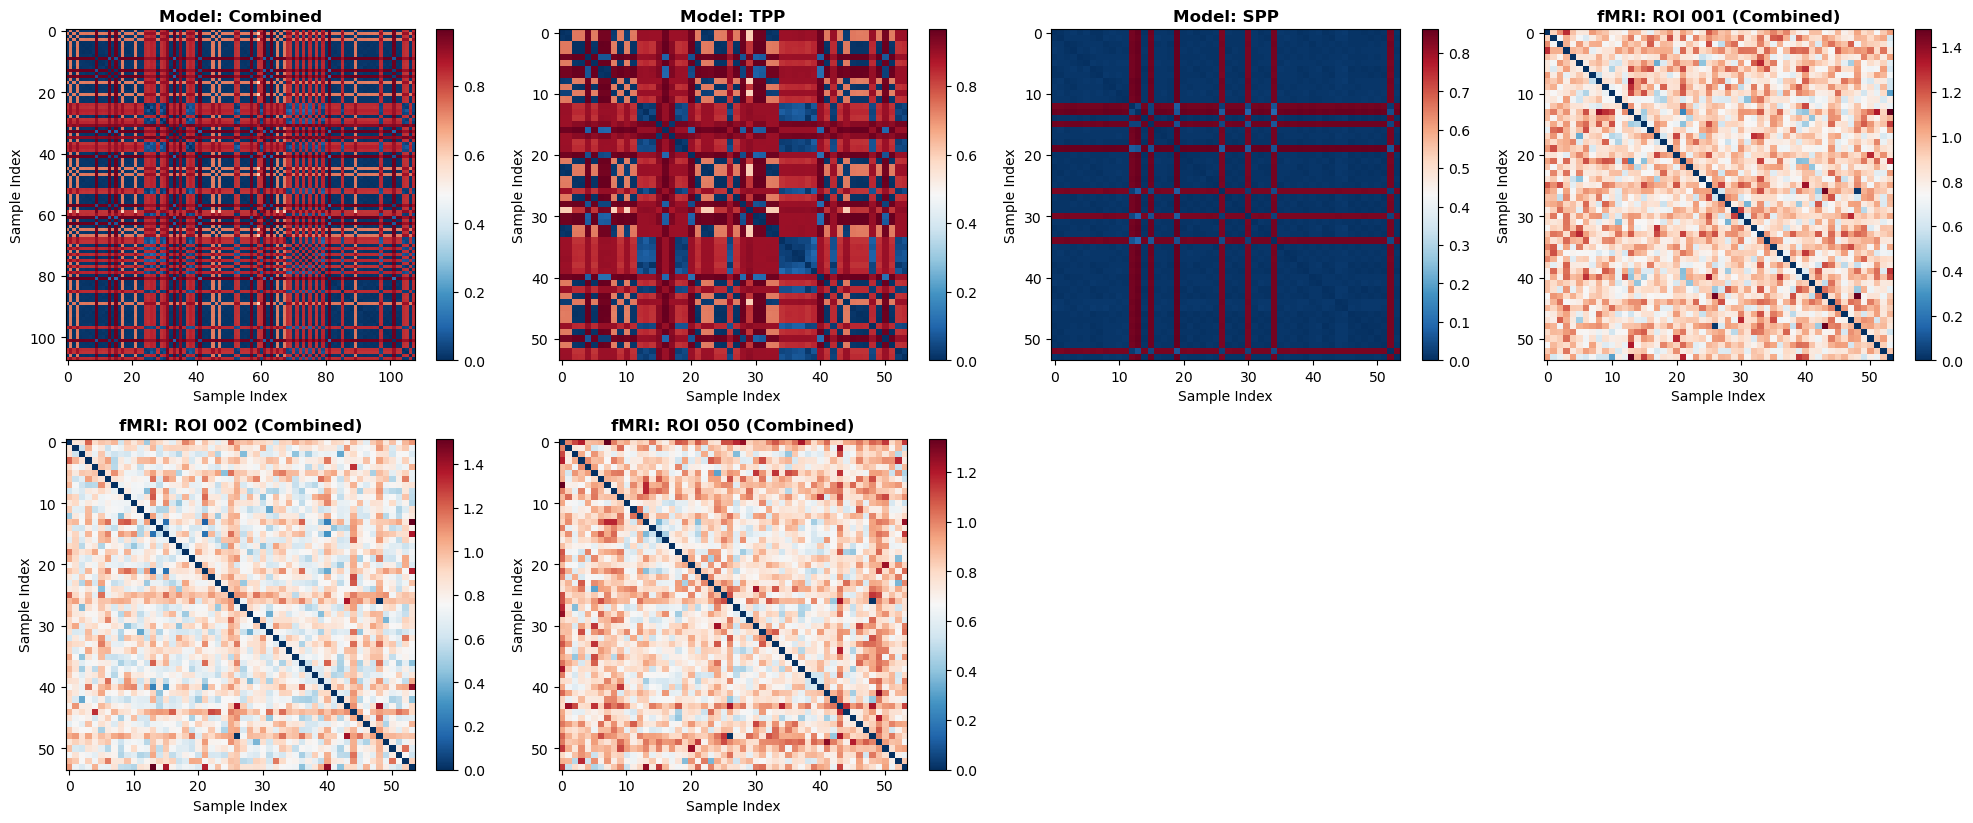


检查完成!


【4】检查文件结构:
--------------------------------------------------------------------------------

找到 166 个ROI文件夹
前10个: ['roi_001', 'roi_002', 'roi_003', 'roi_004', 'roi_005', 'roi_006', 'roi_007', 'roi_008', 'roi_009', 'roi_010']
后10个: ['roi_161', 'roi_162', 'roi_163', 'roi_164', 'roi_165', 'roi_166', 'roi_167', 'roi_168', 'roi_169', 'roi_170']

roi_001 文件夹中的文件:
  - rdm_tpp.npy (23456 bytes)
  - rdm_spp.npy (23456 bytes)
  - rdm_combined.npy (23456 bytes)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

def inspect_rdm_matrices(fmri_rdm_dir='./rsa_results', model_rdm_dir='./rdm_results'):
    """
    检查RDM矩阵的详细信息
    """
    print("=" * 80)
    print("RDM矩阵检查工具")
    print("=" * 80)
    
    # 1. 检查模型RDM
    print("\n【1】模型RDM矩阵信息:")
    print("-" * 80)
    
    model_rdm_files = {
        'all_rdm.npy': 'Combined (All)',
        'tpp_rdm.npy': 'TPP',
        'spp_rdm.npy': 'SPP'
    }
    
    for filename, name in model_rdm_files.items():
        filepath = os.path.join(model_rdm_dir, filename)
        if os.path.exists(filepath):
            rdm = np.load(filepath)
            print(f"\n{name}:")
            print(f"  文件路径: {filepath}")
            print(f"  矩阵形状: {rdm.shape}")
            print(f"  数据类型: {rdm.dtype}")
            print(f"  数值范围: [{rdm.min():.6f}, {rdm.max():.6f}]")
            print(f"  是否对称: {np.allclose(rdm, rdm.T)}")
            print(f"  对角线值: {np.diag(rdm)[:5]}... (前5个)")
            print(f"  矩阵样例 (前5x5):")
            print(rdm[:5, :5])
    
    # 2. 检查fMRI RDM (检查前几个脑区)
    print("\n\n【2】fMRI RDM矩阵信息:")
    print("-" * 80)
    
    roi_ids_to_check = [1, 2, 3, 50, 100]  # 检查几个不同的脑区
    
    for roi_id in roi_ids_to_check:
        roi_folder = f'roi_{roi_id:03d}'
        roi_path = os.path.join(fmri_rdm_dir, roi_folder)
        
        if not os.path.exists(roi_path):
            print(f"\n脑区 {roi_id} (roi_{roi_id:03d}): 文件夹不存在")
            continue
        
        print(f"\n脑区 {roi_id} (roi_{roi_id:03d}):")
        print(f"  文件夹路径: {roi_path}")
        
        fmri_files = {
            'rdm_combined.npy': 'Combined',
            'rdm_tpp.npy': 'TPP',
            'rdm_spp.npy': 'SPP'
        }
        
        for filename, name in fmri_files.items():
            filepath = os.path.join(roi_path, filename)
            if os.path.exists(filepath):
                try:
                    rdm = np.load(filepath)
                    print(f"\n  {name}:")
                    print(f"    文件: {filename}")
                    print(f"    矩阵形状: {rdm.shape}")
                    print(f"    数据类型: {rdm.dtype}")
                    print(f"    数值范围: [{rdm.min():.6f}, {rdm.max():.6f}]")
                    print(f"    是否对称: {np.allclose(rdm, rdm.T)}")
                    
                    # 检查是否有NaN或Inf
                    has_nan = np.any(np.isnan(rdm))
                    has_inf = np.any(np.isinf(rdm))
                    print(f"    包含NaN: {has_nan}")
                    print(f"    包含Inf: {has_inf}")
                    
                    if rdm.shape[0] <= 10:
                        print(f"    完整矩阵:")
                        print(rdm)
                    else:
                        print(f"    矩阵样例 (前5x5):")
                        print(rdm[:5, :5])
                        
                except Exception as e:
                    print(f"    读取失败: {e}")
            else:
                print(f"\n  {name}: 文件不存在")
    
    # 3. 可视化几个RDM矩阵
    print("\n\n【3】生成可视化图形...")
    print("-" * 80)
    
    visualize_rdm_samples(model_rdm_dir, fmri_rdm_dir)
    
    print("\n检查完成!")


def visualize_rdm_samples(model_rdm_dir='./rdm_results', fmri_rdm_dir='./rsa_results'):
    """
    可视化RDM矩阵样本
    """
    fig = plt.figure(figsize=(20, 12))
    
    plot_idx = 1
    
    # 模型RDM
    model_files = [
        ('all_rdm.npy', 'Model: Combined'),
        ('tpp_rdm.npy', 'Model: TPP'),
        ('spp_rdm.npy', 'Model: SPP')
    ]
    
    for filename, title in model_files:
        filepath = os.path.join(model_rdm_dir, filename)
        if os.path.exists(filepath):
            rdm = np.load(filepath)
            
            ax = plt.subplot(3, 4, plot_idx)
            im = ax.imshow(rdm, cmap='RdBu_r', aspect='auto')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel('Sample Index')
            plt.colorbar(im, ax=ax)
            plot_idx += 1
    
    # fMRI RDM (检查前几个脑区)
    roi_ids = [1, 2, 50]
    
    for roi_id in roi_ids:
        roi_folder = f'roi_{roi_id:03d}'
        roi_path = os.path.join(fmri_rdm_dir, roi_folder)
        
        if not os.path.exists(roi_path):
            continue
        
        # 只显示combined
        filepath = os.path.join(roi_path, 'rdm_combined.npy')
        if os.path.exists(filepath):
            try:
                rdm = np.load(filepath)
                
                ax = plt.subplot(3, 4, plot_idx)
                im = ax.imshow(rdm, cmap='RdBu_r', aspect='auto')
                ax.set_title(f'fMRI: ROI {roi_id:03d} (Combined)', fontsize=12, fontweight='bold')
                ax.set_xlabel('Sample Index')
                ax.set_ylabel('Sample Index')
                plt.colorbar(im, ax=ax)
                plot_idx += 1
            except Exception as e:
                print(f"可视化脑区 {roi_id} 时出错: {e}")
    
    plt.tight_layout()
    
    # 保存图形
    os.makedirs('./inspection_figures', exist_ok=True)
    plt.savefig('./inspection_figures/rdm_samples.png', dpi=150, bbox_inches='tight')
    print("可视化图形已保存到: ./inspection_figures/rdm_samples.png")
    
    plt.show()


def check_file_structure(fmri_rdm_dir='./rsa_results'):
    """
    检查文件结构
    """
    print("\n\n【4】检查文件结构:")
    print("-" * 80)
    
    if not os.path.exists(fmri_rdm_dir):
        print(f"目录不存在: {fmri_rdm_dir}")
        return
    
    # 列出所有roi文件夹
    roi_folders = [f for f in os.listdir(fmri_rdm_dir) if f.startswith('roi_')]
    roi_folders.sort()
    
    print(f"\n找到 {len(roi_folders)} 个ROI文件夹")
    print(f"前10个: {roi_folders[:10]}")
    print(f"后10个: {roi_folders[-10:]}")
    
    # 检查第一个ROI文件夹的内容
    if roi_folders:
        first_roi = roi_folders[0]
        first_roi_path = os.path.join(fmri_rdm_dir, first_roi)
        files = os.listdir(first_roi_path)
        print(f"\n{first_roi} 文件夹中的文件:")
        for f in files:
            filepath = os.path.join(first_roi_path, f)
            if f.endswith('.npy'):
                size = os.path.getsize(filepath)
                print(f"  - {f} ({size} bytes)")


if __name__ == '__main__':
    # 检查RDM矩阵
    inspect_rdm_matrices()
    
    # 检查文件结构
    check_file_structure()

In [8]:
import numpy as np
import os

# 快速检查fMRI RDM的实际形状
fmri_rdm_dir = './rsa_results'
roi_folder = 'roi_001'
roi_path = os.path.join(fmri_rdm_dir, roi_folder)

print("检查 roi_001 的RDM矩阵形状:")
for filename in ['rdm_combined.npy', 'rdm_tpp.npy', 'rdm_spp.npy']:
    filepath = os.path.join(roi_path, filename)
    if os.path.exists(filepath):
        rdm = np.load(filepath)
        print(f"{filename}: {rdm.shape}")

检查 roi_001 的RDM矩阵形状:
rdm_combined.npy: (54, 54)
rdm_tpp.npy: (54, 54)
rdm_spp.npy: (54, 54)


RDM相似度分析

已加载 170 个脑区标签
已创建 124 个脑区名称映射
模型RDM矩阵形状: All=(108, 108), TPP=(54, 54), SPP=(54, 54)

正在计算所有脑区的RDM相似度...

成功分析的脑区数量:
  - Combined: 166 个脑区
  - TPP: 166 个脑区
  - SPP: 166 个脑区

正在保存结果...
结果已保存到: ./similarity_results/similarity_all.txt
结果已保存到: ./similarity_results/similarity_tpp.txt
结果已保存到: ./similarity_results/similarity_spp.txt

正在生成Top 30脑区的可视化图形（使用缩写）...
图形已保存到: ./figures/similarity_combined_top30_abbrev.png


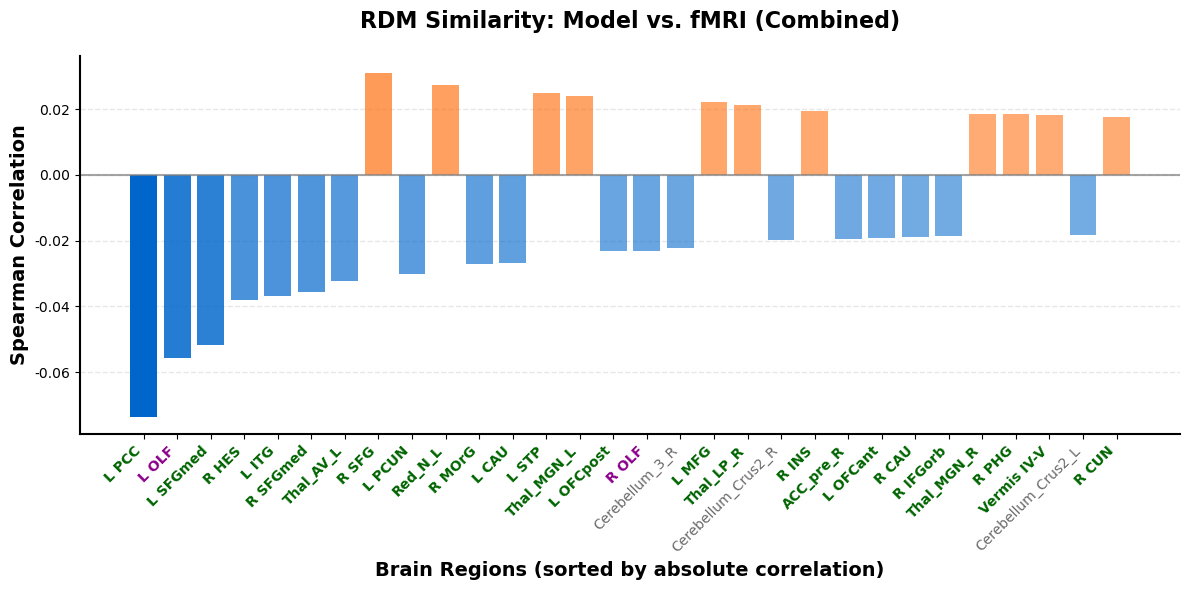


=== Top 50 Regions by Absolute Correlation (Combined) ===
 1. Cingulate_Post_L               | left posterior cingulate cortex                         [L PCC       ] (ROI  39): -0.0736 [DECISION]
 2. Olfactory_L                    | left olfactory cortex                                   [L OLF       ] (ROI  17): -0.0558 [EMOTION]
 3. Frontal_Sup_Medial_L           | left superior frontal gyrus, medial                     [L SFGmed    ] (ROI  19): -0.0518 [DECISION]
 4. Heschl_R                       | right Heschl gyrus                                      [R HES       ] (ROI  84): -0.0379 [DECISION]
 5. Temporal_Inf_L                 | left inferior temporal gyrus                            [L ITG       ] (ROI  93): -0.0368 [DECISION]
 6. Frontal_Sup_Medial_R           | right superior frontal gyrus, medial                    [R SFGmed    ] (ROI  20): -0.0356 [DECISION]
 7. Thal_AV_L                      | Thal_AV_L                                               [Thal_AV_L   ] (ROI 1

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os
from pathlib import Path

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class RDMAnalyzer:
    def __init__(self, model_rdm_dir='./rdm_results', 
                 fmri_rdm_dir='./rsa_results',
                 labels_file='./atlas/AAL3v1_labels.txt'):
        """
        初始化RDM分析器
        
        Parameters:
        -----------
        model_rdm_dir : str
            大模型RDM矩阵目录
        fmri_rdm_dir : str
            fMRI RDM矩阵目录
        labels_file : str
            脑区标签文件路径
        """
        self.model_rdm_dir = model_rdm_dir
        self.fmri_rdm_dir = fmri_rdm_dir
        self.labels_file = labels_file
        
        # 加载大模型RDM
        self.model_rdm_all = np.load(os.path.join(model_rdm_dir, 'all_rdm.npy'))
        self.model_rdm_tpp = np.load(os.path.join(model_rdm_dir, 'tpp_rdm.npy'))
        self.model_rdm_spp = np.load(os.path.join(model_rdm_dir, 'spp_rdm.npy'))
        
        # 加载脑区标签
        self.roi_labels = self.load_roi_labels()
        
        # 创建AAL3名称到完整解剖名称的映射
        self.name_mapping = self.create_name_mapping()
        
    def load_roi_labels(self):
        """加载脑区标签"""
        labels = {}
        with open(self.labels_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    roi_id = int(parts[0])
                    roi_name = parts[1]
                    labels[roi_id] = roi_name
        return labels
    
    def create_name_mapping(self):
        """
        创建AAL3模板名称到完整解剖名称的映射
        
        Returns:
        --------
        mapping : dict
            名称映射字典，格式为 {'AAL3_name': ('full_name', 'abbreviation')}
        """
        mapping = {
            # Frontal lobe - Superior
            'Frontal_Sup_2_L': ('left superior frontal gyrus', 'L SFG'),
            'Frontal_Sup_2_R': ('right superior frontal gyrus', 'R SFG'),
            'Frontal_Sup_L': ('left superior frontal gyrus', 'L SFG'),
            'Frontal_Sup_R': ('right superior frontal gyrus', 'R SFG'),
            
            # Frontal lobe - Middle
            'Frontal_Mid_2_L': ('left middle frontal gyrus', 'L MFG'),
            'Frontal_Mid_2_R': ('right middle frontal gyrus', 'R MFG'),
            'Frontal_Mid_L': ('left middle frontal gyrus', 'L MFG'),
            'Frontal_Mid_R': ('right middle frontal gyrus', 'R MFG'),
            
            # Frontal lobe - Inferior
            'Frontal_Inf_Oper_L': ('left inferior frontal gyrus, opercular part', 'L IFGoper'),
            'Frontal_Inf_Oper_R': ('right inferior frontal gyrus, opercular part', 'R IFGoper'),
            'Frontal_Inf_Tri_L': ('left inferior frontal gyrus, triangular part', 'L IFGtri'),
            'Frontal_Inf_Tri_R': ('right inferior frontal gyrus, triangular part', 'R IFGtri'),
            'Frontal_Inf_Orb_2_L': ('left inferior frontal gyrus, orbital part', 'L IFGorb'),
            'Frontal_Inf_Orb_2_R': ('right inferior frontal gyrus, orbital part', 'R IFGorb'),
            
            # Rolandic and motor areas
            'Rolandic_Oper_L': ('left rolandic operculum', 'L ROL'),
            'Rolandic_Oper_R': ('right rolandic operculum', 'R ROL'),
            'Supp_Motor_Area_L': ('left supplementary motor area', 'L SMA'),
            'Supp_Motor_Area_R': ('right supplementary motor area', 'R SMA'),
            'Precentral_L': ('left precentral gyrus', 'L PreCG'),
            'Precentral_R': ('right precentral gyrus', 'R PreCG'),
            'Postcentral_L': ('left postcentral gyrus', 'L PostCG'),
            'Postcentral_R': ('right postcentral gyrus', 'R PostCG'),
            
            # Olfactory and medial frontal
            'Olfactory_L': ('left olfactory cortex', 'L OLF'),
            'Olfactory_R': ('right olfactory cortex', 'R OLF'),
            'Frontal_Sup_Medial_L': ('left superior frontal gyrus, medial', 'L SFGmed'),
            'Frontal_Sup_Medial_R': ('right superior frontal gyrus, medial', 'R SFGmed'),
            'Frontal_Med_Orb_L': ('left medial orbital gyrus', 'L MOrG'),
            'Frontal_Med_Orb_R': ('right medial orbital gyrus', 'R MOrG'),
            'Rectus_L': ('left rectus gyrus', 'L REC'),
            'Rectus_R': ('right rectus gyrus', 'R REC'),
            
            # Orbitofrontal cortex
            'OFCmed_L': ('left medial orbitofrontal cortex', 'L OFCmed'),
            'OFCmed_R': ('right medial orbitofrontal cortex', 'R OFCmed'),
            'OFCant_L': ('left anterior orbitofrontal cortex', 'L OFCant'),
            'OFCant_R': ('right anterior orbitofrontal cortex', 'R OFCant'),
            'OFCpost_L': ('left posterior orbitofrontal cortex', 'L OFCpost'),
            'OFCpost_R': ('right posterior orbitofrontal cortex', 'R OFCpost'),
            'OFClat_L': ('left lateral orbitofrontal cortex', 'L OFClat'),
            'OFClat_R': ('right lateral orbitofrontal cortex', 'R OFClat'),
            
            # Parietal lobe - Superior and Inferior
            'Parietal_Sup_L': ('left superior parietal gyrus', 'L SPG'),
            'Parietal_Sup_R': ('right superior parietal gyrus', 'R SPG'),
            'Parietal_Inf_L': ('left inferior parietal gyrus', 'L IPG'),
            'Parietal_Inf_R': ('right inferior parietal gyrus', 'R IPG'),
            'SupraMarginal_L': ('left supramarginal gyrus', 'L SMG'),
            'SupraMarginal_R': ('right supramarginal gyrus', 'R SMG'),
            'Angular_L': ('left angular gyrus', 'L ANG'),
            'Angular_R': ('right angular gyrus', 'R ANG'),
            
            # Parietal lobe - Medial
            'Precuneus_L': ('left precuneus', 'L PCUN'),
            'Precuneus_R': ('right precuneus', 'R PCUN'),
            'Paracentral_Lobule_L': ('left paracentral lobule', 'L PCL'),
            'Paracentral_Lobule_R': ('right paracentral lobule', 'R PCL'),
            
            # Temporal lobe - Superior
            'Temporal_Sup_L': ('left superior temporal gyrus', 'L STG'),
            'Temporal_Sup_R': ('right superior temporal gyrus', 'R STG'),
            'Temporal_Pole_Sup_L': ('left superior temporal pole', 'L STP'),
            'Temporal_Pole_Sup_R': ('right superior temporal pole', 'R STP'),
            
            # Temporal lobe - Middle
            'Temporal_Mid_L': ('left middle temporal gyrus', 'L MTG'),
            'Temporal_Mid_R': ('right middle temporal gyrus', 'R MTG'),
            'Temporal_Pole_Mid_L': ('left middle temporal pole', 'L MTP'),
            'Temporal_Pole_Mid_R': ('right middle temporal pole', 'R MTP'),
            
            # Temporal lobe - Inferior
            'Temporal_Inf_L': ('left inferior temporal gyrus', 'L ITG'),
            'Temporal_Inf_R': ('right inferior temporal gyrus', 'R ITG'),
            
            # Auditory cortex
            'Heschl_L': ('left Heschl gyrus', 'L HES'),
            'Heschl_R': ('right Heschl gyrus', 'R HES'),
            
            # Occipital lobe
            'Calcarine_L': ('left calcarine cortex', 'L CAL'),
            'Calcarine_R': ('right calcarine cortex', 'R CAL'),
            'Cuneus_L': ('left cuneus', 'L CUN'),
            'Cuneus_R': ('right cuneus', 'R CUN'),
            'Lingual_L': ('left lingual gyrus', 'L LING'),
            'Lingual_R': ('right lingual gyrus', 'R LING'),
            'Occipital_Sup_L': ('left superior occipital gyrus', 'L SOG'),
            'Occipital_Sup_R': ('right superior occipital gyrus', 'R SOG'),
            'Occipital_Mid_L': ('left middle occipital gyrus', 'L MOG'),
            'Occipital_Mid_R': ('right middle occipital gyrus', 'R MOG'),
            'Occipital_Inf_L': ('left inferior occipital gyrus', 'L IOG'),
            'Occipital_Inf_R': ('right inferior occipital gyrus', 'R IOG'),
            'Fusiform_L': ('left fusiform gyrus', 'L FFG'),
            'Fusiform_R': ('right fusiform gyrus', 'R FFG'),
            
            # Cingulate cortex
            'Cingulate_Ant_L': ('left anterior cingulate cortex', 'L ACC'),
            'Cingulate_Ant_R': ('right anterior cingulate cortex', 'R ACC'),
            'Cingulate_Mid_L': ('left middle cingulate cortex', 'L MCC'),
            'Cingulate_Mid_R': ('right middle cingulate cortex', 'R MCC'),
            'Cingulate_Post_L': ('left posterior cingulate cortex', 'L PCC'),
            'Cingulate_Post_R': ('right posterior cingulate cortex', 'R PCC'),
            
            # Medial temporal lobe
            'Hippocampus_L': ('left hippocampus', 'L HIP'),
            'Hippocampus_R': ('right hippocampus', 'R HIP'),
            'ParaHippocampal_L': ('left parahippocampal gyrus', 'L PHG'),
            'ParaHippocampal_R': ('right parahippocampal gyrus', 'R PHG'),
            'Amygdala_L': ('left amygdala', 'L AMYG'),
            'Amygdala_R': ('right amygdala', 'R AMYG'),
            
            # Insula
            'Insula_L': ('left insula', 'L INS'),
            'Insula_R': ('right insula', 'R INS'),
            
            # Basal ganglia
            'Caudate_L': ('left caudate nucleus', 'L CAU'),
            'Caudate_R': ('right caudate nucleus', 'R CAU'),
            'Putamen_L': ('left putamen', 'L PUT'),
            'Putamen_R': ('right putamen', 'R PUT'),
            'Pallidum_L': ('left pallidum', 'L PAL'),
            'Pallidum_R': ('right pallidum', 'R PAL'),
            
            # Thalamus
            'Thalamus_L': ('left thalamus', 'L THA'),
            'Thalamus_R': ('right thalamus', 'R THA'),
            
            # Cerebellum - Lateral
            'Cerebelum_Crus1_L': ('left cerebellum crus I', 'L Crus I'),
            'Cerebelum_Crus1_R': ('right cerebellum crus I', 'R Crus I'),
            'Cerebelum_Crus2_L': ('left cerebellum crus II', 'L Crus II'),
            'Cerebelum_Crus2_R': ('right cerebellum crus II', 'R Crus II'),
            'Cerebelum_3_L': ('left cerebellum III', 'L Cb III'),
            'Cerebelum_3_R': ('right cerebellum III', 'R Cb III'),
            'Cerebelum_4_5_L': ('left cerebellum IV-V', 'L Cb IV-V'),
            'Cerebelum_4_5_R': ('right cerebellum IV-V', 'R Cb IV-V'),
            'Cerebelum_6_L': ('left cerebellum VI', 'L Cb VI'),
            'Cerebelum_6_R': ('right cerebellum VI', 'R Cb VI'),
            'Cerebelum_7b_L': ('left cerebellum VIIb', 'L Cb VIIb'),
            'Cerebelum_7b_R': ('right cerebellum VIIb', 'R Cb VIIb'),
            'Cerebelum_8_L': ('left cerebellum VIII', 'L Cb VIII'),
            'Cerebelum_8_R': ('right cerebellum VIII', 'R Cb VIII'),
            'Cerebelum_9_L': ('left cerebellum IX', 'L Cb IX'),
            'Cerebelum_9_R': ('right cerebellum IX', 'R Cb IX'),
            'Cerebelum_10_L': ('left cerebellum X', 'L Cb X'),
            'Cerebelum_10_R': ('right cerebellum X', 'R Cb X'),
            
            # Cerebellar vermis
            'Vermis_1_2': ('cerebellar vermis I-II', 'Vermis I-II'),
            'Vermis_3': ('cerebellar vermis III', 'Vermis III'),
            'Vermis_4_5': ('cerebellar vermis IV-V', 'Vermis IV-V'),
            'Vermis_6': ('cerebellar vermis VI', 'Vermis VI'),
            'Vermis_7': ('cerebellar vermis VII', 'Vermis VII'),
            'Vermis_8': ('cerebellar vermis VIII', 'Vermis VIII'),
            'Vermis_9': ('cerebellar vermis IX', 'Vermis IX'),
            'Vermis_10': ('cerebellar vermis X', 'Vermis X'),
        }
        
        return mapping
    
    def get_full_name(self, aal_name, use_abbreviation=False):
        """
        获取AAL3名称对应的完整解剖名称或缩写
        
        Parameters:
        -----------
        aal_name : str
            AAL3模板名称
        use_abbreviation : bool
            是否使用缩写（默认False，使用完整名称）
            
        Returns:
        --------
        name : str
            完整解剖名称或缩写
        """
        if aal_name in self.name_mapping:
            full_name, abbrev = self.name_mapping[aal_name]
            return abbrev if use_abbreviation else full_name
        return aal_name
    
    def compute_rdm_similarity(self, rdm1, rdm2):
        """
        计算两个RDM矩阵的相似度（使用Spearman相关）
        
        Parameters:
        -----------
        rdm1, rdm2 : numpy.ndarray
            RDM矩阵
            
        Returns:
        --------
        correlation : float
            Spearman相关系数
        """
        # 提取上三角部分（不包括对角线）
        triu_indices = np.triu_indices_from(rdm1, k=1)
        rdm1_vector = rdm1[triu_indices]
        rdm2_vector = rdm2[triu_indices]
        
        # 计算Spearman相关
        correlation, _ = spearmanr(rdm1_vector, rdm2_vector)
        
        return correlation
    
    def analyze_all_rois(self):
        """分析所有脑区的RDM相似度"""
        results = {
            'all': {},
            'tpp': {},
            'spp': {}
        }
        
        # 遍历所有脑区文件夹
        for roi_id in range(1, 171):  # roi_001 到 roi_170
            roi_folder = f'roi_{roi_id:03d}'
            roi_path = os.path.join(self.fmri_rdm_dir, roi_folder)
            
            if not os.path.exists(roi_path):
                continue
            
            try:
                # 加载该脑区的RDM矩阵
                rdm_all_path = os.path.join(roi_path, 'rdm_combined.npy')
                rdm_tpp_path = os.path.join(roi_path, 'rdm_tpp.npy')
                rdm_spp_path = os.path.join(roi_path, 'rdm_spp.npy')
                
                if os.path.exists(rdm_all_path):
                    fmri_rdm_all = np.load(rdm_all_path)
                    sim_all = self.compute_rdm_similarity(self.model_rdm_all, fmri_rdm_all)
                    results['all'][roi_id] = sim_all
                
                if os.path.exists(rdm_tpp_path):
                    fmri_rdm_tpp = np.load(rdm_tpp_path)
                    sim_tpp = self.compute_rdm_similarity(self.model_rdm_tpp, fmri_rdm_tpp)
                    results['tpp'][roi_id] = sim_tpp
                
                if os.path.exists(rdm_spp_path):
                    fmri_rdm_spp = np.load(rdm_spp_path)
                    sim_spp = self.compute_rdm_similarity(self.model_rdm_spp, fmri_rdm_spp)
                    results['spp'][roi_id] = sim_spp
                    
            except Exception as e:
                print(f"处理脑区 {roi_id} 时出错: {e}")
                continue
        
        return results
    
    def plot_results(self, results, condition='all', top_n=None, use_abbreviation=True, 
                    figsize=(12, 6), save_path=None):
        """
        可视化RDM相似度结果
        
        Parameters:
        -----------
        results : dict
            分析结果
        condition : str
            条件类型 ('all', 'tpp', 'spp')
        top_n : int, optional
            只显示前N个脑区，None表示显示全部
        use_abbreviation : bool
            是否使用缩写（默认True）
        figsize : tuple
            图形大小
        save_path : str, optional
            保存路径
        """
        data = results[condition]
        
        # 按绝对值大小排序（从大到小）
        sorted_rois = sorted(data.items(), key=lambda x: abs(x[1]), reverse=True)
        
        if top_n:
            sorted_rois = sorted_rois[:top_n]
        
        roi_ids = [roi_id for roi_id, _ in sorted_rois]
        similarities = [sim for _, sim in sorted_rois]
        
        # 定义决策相关和情绪相关的脑区（基于AAL3名称）
        decision_regions = {
            'Cingulate_Post_L', 'Frontal_Sup_Medial_L', 'Heschl_R', 'Temporal_Inf_L',
            'Frontal_Sup_Medial_R', 'Thal_AV_L', 'Frontal_Sup_2_R', 'Precuneus_L',
            'Red_N_L', 'Frontal_Med_Orb_R', 'Caudate_L', 'Temporal_Pole_Sup_L',
            'Thal_MGN_L', 'OFCpost_L', 'Cerebelum_3_R', 'Frontal_Mid_2_L',
            'Thal_LP_R', 'Cerebelum_Crus2_R', 'Insula_R', 'ACC_pre_R',
            'OFCant_L', 'Caudate_R', 'Frontal_Inf_Orb_2_R', 'Thal_MGN_R',
            'ParaHippocampal_R', 'Vermis_4_5', 'Cerebelum_Crus2_L', 'Cuneus_R'
        }
        
        emotion_regions = {
            'Olfactory_L', 'Olfactory_R'
        }
        
        # 使用完整解剖名称或缩写
        roi_names = []
        roi_categories = []  # 用于记录每个脑区的类别
        for roi_id in roi_ids:
            aal_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
            display_name = self.get_full_name(aal_name, use_abbreviation=use_abbreviation)
            roi_names.append(display_name)
            
            # 判断脑区类别
            if aal_name in decision_regions:
                roi_categories.append('decision')
            elif aal_name in emotion_regions:
                roi_categories.append('emotion')
            else:
                roi_categories.append('other')
        
        # 创建图形
        fig, ax = plt.subplots(figsize=figsize)
        
        # 为每个柱子分配颜色（正值暖色调，负值冷色调，随绝对值变小颜色变淡）
        colors = []
        max_abs_value = max(abs(s) for s in similarities) if similarities else 1

        for sim in similarities:
            if sim >= 0:
                # 正值：使用橙红色系 - 更鲜明的暖色调
                alpha = 0.4 + 0.6 * (abs(sim) / max_abs_value)  # 范围从0.4到1.0
                colors.append((1.0, 0.4, 0.0, alpha))  # 鲜橙色 (#FF6600)
            else:
                # 负值：使用深蓝色系 - 更鲜明的冷色调
                alpha = 0.4 + 0.6 * (abs(sim) / max_abs_value)  # 范围从0.4到1.0
                colors.append((0.0, 0.4, 0.8, alpha))  # 深蓝色 (#0066CC)
        
        # 绘制柱状图
        bars = ax.bar(range(len(similarities)), similarities, 
                    color=colors, edgecolor='none')
        
        # 设置坐标轴
        ax.set_ylabel('Spearman Correlation', fontsize=14, fontweight='bold')
        ax.set_xlabel('Brain Regions (sorted by absolute correlation)', fontsize=14, fontweight='bold')
        
        # 设置标题
        condition_names = {'all': 'Combined', 'tpp': 'TPP', 'spp': 'SPP'}
        ax.set_title(f'RDM Similarity: Model vs. fMRI ({condition_names[condition]})', 
                    fontsize=16, fontweight='bold', pad=20)
        
        # 取消上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置x轴刻度 - 根据脑区类别设置不同颜色
        ax.set_xticks(range(len(roi_names)))
        ax.set_xticklabels(roi_names, rotation=45, ha='right', fontsize=10)  # 修改为45度倾斜，字体增大到11

        
        # 为x轴标签设置不同颜色
        for i, (label, category) in enumerate(zip(ax.get_xticklabels(), roi_categories)):
            if category == 'decision':
                label.set_color('#006400')  # 决策相关：深绿色 (DarkGreen)
                label.set_fontweight('bold')
            elif category == 'emotion':
                label.set_color('#8B008B')  # 情绪相关：深洋红色 (DarkMagenta)
                label.set_fontweight('bold')
            else:
                label.set_color('#696969')  # 其他：暗灰色 (DimGray)

        # 添加图例说明x轴颜色含义
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#006400', label='Decision-related regions'),
            Patch(facecolor='#8B008B', label='Emotion-related regions'),
            Patch(facecolor='#696969', label='Other regions')
        ]
        
        # 设置网格
        ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=1)
        ax.set_axisbelow(True)
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7)
        
        # # 添加图例说明x轴颜色含义
        # from matplotlib.patches import Patch
        # legend_elements = [
        #     Patch(facecolor='#D35400', label='Decision-related regions'),
        #     Patch(facecolor='#2874A6', label='Emotion-related regions'),
        #     Patch(facecolor='#5D6D7E', label='Other regions')
        # ]
        # ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
        #         fancybox=True, shadow=True, fontsize=10)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图形
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图形已保存到: {save_path}")
        
        plt.show()
        
        # 打印前50名（按绝对值）- 使用完整名称，包含AAL3原始名称，并标注类别
        print(f"\n=== Top 50 Regions by Absolute Correlation ({condition_names[condition]}) ===")
        for i, (roi_id, sim) in enumerate(sorted_rois[:50], 1):
            aal_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
            full_name = self.get_full_name(aal_name, use_abbreviation=False)
            abbrev = self.get_full_name(aal_name, use_abbreviation=True)
            
            # 确定类别标签
            if aal_name in decision_regions:
                category_label = "[DECISION]"
            elif aal_name in emotion_regions:
                category_label = "[EMOTION]"
            else:
                category_label = ""
            
            print(f"{i:2d}. {aal_name:30s} | {full_name:55s} [{abbrev:12s}] (ROI {roi_id:3d}): {sim:+.4f} {category_label}")
    
    def save_results(self, results, output_dir='./similarity_results'):
        """保存结果到文件"""
        os.makedirs(output_dir, exist_ok=True)
        
        for condition in ['all', 'tpp', 'spp']:
            data = results[condition]
            sorted_rois = sorted(data.items(), key=lambda x: abs(x[1]), reverse=True)
            
            output_file = os.path.join(output_dir, f'similarity_{condition}.txt')
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"ROI_ID\tAAL3_Name\tFull_Name\tAbbreviation\tSpearman_Correlation\tAbs_Correlation\n")
                for roi_id, sim in sorted_rois:
                    aal_name = self.roi_labels.get(roi_id, f'ROI_{roi_id}')
                    full_name = self.get_full_name(aal_name, use_abbreviation=False)
                    abbrev = self.get_full_name(aal_name, use_abbreviation=True)
                    f.write(f"{roi_id}\t{aal_name}\t{full_name}\t{abbrev}\t{sim:.6f}\t{abs(sim):.6f}\n")
            
            print(f"结果已保存到: {output_file}")
            
            # 同时保存为numpy格式
            np.save(os.path.join(output_dir, f'similarity_{condition}.npy'), 
                   np.array([(roi_id, sim) for roi_id, sim in sorted_rois]))


def main():
    """主函数"""
    print("=" * 60)
    print("RDM相似度分析")
    print("=" * 60)
    
    # 创建分析器
    analyzer = RDMAnalyzer()
    
    print(f"\n已加载 {len(analyzer.roi_labels)} 个脑区标签")
    print(f"已创建 {len(analyzer.name_mapping)} 个脑区名称映射")
    print(f"模型RDM矩阵形状: All={analyzer.model_rdm_all.shape}, "
          f"TPP={analyzer.model_rdm_tpp.shape}, SPP={analyzer.model_rdm_spp.shape}")
    
    # 分析所有脑区
    print("\n正在计算所有脑区的RDM相似度...")
    results = analyzer.analyze_all_rois()
    
    print(f"\n成功分析的脑区数量:")
    print(f"  - Combined: {len(results['all'])} 个脑区")
    print(f"  - TPP: {len(results['tpp'])} 个脑区")
    print(f"  - SPP: {len(results['spp'])} 个脑区")
    
    # 保存结果
    print("\n正在保存结果...")
    analyzer.save_results(results)
    
    # 创建输出目录
    os.makedirs('./figures', exist_ok=True)
    
    # 只显示前30个脑区（按绝对值排序）
    # use_abbreviation=True 使用缩写，use_abbreviation=False 使用完整名称
    print("\n正在生成Top 30脑区的可视化图形（使用缩写）...")
    analyzer.plot_results(results, condition='all', top_n=30, use_abbreviation=True,
                         save_path='./figures/similarity_combined_top30_abbrev.png')
    
    
    # 如果需要使用完整名称，可以取消下面的注释
    # print("\n正在生成Top 30脑区的可视化图形（使用完整名称）...")
    # analyzer.plot_results(results, condition='all', top_n=30, use_abbreviation=False,
    #                      save_path='./figures/similarity_combined_top30_full.png')
    
    print("\n分析完成！")


if __name__ == '__main__':
    main()
